## Milestone 1 SIRD part coding 

## Step 1: import the dataset to a pandas dataframe

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as dates
import seaborn as sns; sns.set()
import numpy as np
import pylab 
import scipy.stats as stats
from scipy.integrate import solve_ivp
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot_2samples
import math
import copy
import warnings
import os
import csv
import copy
warnings.filterwarnings('ignore')

##Load data
path = "clean-data/US.csv"
dataUS = pd.read_csv(path, header=None).values.tolist()
#dataSize = len(dataUS.index)
#print(dataUS)
# dataStates = pd.read_csv("us-states.csv")
# dataStateSize = len(dataStates.index)

#print(dataUS.loc[0], dataSize, "\n")
# if (dataUS.loc[1]["date"]>dataUS.loc[0]["date"]):
#     print("nice")

## Step 2. Build SIRD model

In [2]:
# Ref: https://github.com/TomNicholas/coronavirus/blob/master/covid-19_model.ipynb
class SIRD:
    def __init__(self, R0, M, P):
        # Model parameters
        self.R0 = R0
        self.M = M
        self.P = P

    def dSdt(self, S, I, lamb):
        return -lamb*S*I

    def dIdt(self, S, I, lamb, gamma, mu):
        return lamb*S*I - gamma*I - mu*I

    def dRdt(self, I, gamma):
        return gamma*I

    def dDdt(self, I, mu):
        return mu*I
        
    def eqns(self, t, y, lamb, gamma, mu):
        S, I, R, D = y
        return [self.dSdt(S, I, lamb),
                self.dIdt(S, I, lamb, gamma, mu), 
                self.dRdt(I, gamma),
                self.dDdt(I, mu)]
    
    def setup(self, population, deaths):
        # Compute coefficients
        self.gamma = 1 / self.P
        self.mu = self.gamma * self.M
        self.lamb = self.R0 * (self.gamma + self.mu)
        # Compute initial values
        self.population = population
        initial_D = deaths[1] / population
        old_I = initial_D / self.mu
        initial_R = old_I * self.gamma
        # initial state with death and recovery
        old_S = 1 - old_I - (deaths[0] / population) - ((deaths[1] / population)/self.mu) * self.gamma
        initial_S = old_S - self.lamb*old_I*old_S
        initial_I = 1 - initial_S -initial_D - initial_R
        self.y0 = [initial_S, initial_I, initial_R, initial_D]
        #print(old_I,old_S,self.y0)

    def solve(self, initial_conditions, tf):
        self.setup(initial_conditions['population'],
                   initial_conditions['deaths'])
        t_span = (0, tf)  # tf is number of days to run simulation for
        #print(tf)
        self.soln = solve_ivp(self.eqns, t_span, self.y0,
                              args=(self.lamb, self.gamma, self.mu),
                              t_eval=np.linspace(0, tf, tf))
        return self
    
    def plot(self, data, date,fig, check=True, ax=None, name="US", susceptible=True):
        # plot real data to compare
        usDeathT = np.array(data).transpose()
        numDeath = usDeathT[1].astype(np.int)
        converted_dates = dates.datestr2num(usDeathT[0])
        S, I, R, D = self.soln.y
        N = self.population
        D_temp = []
        for x in range(len(D)):
            if x == 0:
                D_temp.append(D[0])
            else:
                D_temp.append(D[x]-D[x-1])
        D_daily = np.array(D_temp)
        usDeathD = copy.deepcopy(data)
        x = 0
        for x in range(len(usDeathD)):
            if usDeathD[x][0] == date:
                break
        #print(len(usDeathD), x,len(D_temp), len(D)) 
        for i in range(len(D_temp)):
            usDeathD[x+i][1] = D_temp[i]*N
        usDeathDT = np.array(usDeathD).transpose()
        numDeathD = usDeathDT[1].astype(np.float)
        #print(usDeathD[x][0],x, usDeathD) 
        #print("D: ",type(D), D[0], "\n daily: ",D_daily[0], usDeathD)
        #print(len(converted_dates),len(D_daily),len(numDeath))
        t = self.soln.t
        print(f"SIRD simulation starts on {date} in {name}:")
        print(f"For a population of {N} people, after {t[-1]:.0f} days there were:")
        print(f"{D[-1]*100:.1f}% total deaths, or {D[-1]*N:.0f} people.")
        print(f"{R[-1]*100:.1f}% total recovered, or {R[-1]*N:.0f} people.")
        print(f"At the virus' maximum {I.max()*100:.1f}% people were simultaneously infected, or {I.max()*N:.0f} people.")
        print(f"After {t[-1]:.0f} days the virus was present in less than {I[-1]*N:.0f} individuals.\n")
        if ax is None:
            fig, ax = plt.subplots(figsize=(20, 10))
#         if susceptible:
#             ax.plot(t, S*N, label="Susceptible", linewidth=2)
#         ax.plot(t, I*N, label="Infected", linewidth=2)
#         ax.plot(t, R*N, label="Recovered", linewidth=2)
        ax.xaxis_date()
        fig.autofmt_xdate()
        plt.xlabel("Date")
        plt.ylabel("Number of new deaths")
        plt.title("SIRD model of daily new deaths in "+name)
        ax.plot(converted_dates, numDeathD, label="SIRD starts on " + date, linewidth=2)
        if(check != False):
            ax.plot(converted_dates, numDeath, label="Real data", linewidth=2, color = "black")
        ax.legend()

       

## Step 3: EDA 
### Step 3.1: Plot the line chart of US daily new deaths

SIRD simulation starts on 2020-03-01 in US:
For a population of 328239523 people, after 350 days there were:
0.9% total deaths, or 2837999 people.
86.5% total recovered, or 283799908 people.
At the virus' maximum 21.8% people were simultaneously infected, or 71559775 people.
After 350 days the virus was present in less than 54 individuals.

SIRD simulation starts on 2020-03-21 in US:
For a population of 328239523 people, after 330 days there were:
0.9% total deaths, or 2858240 people.
87.1% total recovered, or 285824014 people.
At the virus' maximum 21.9% people were simultaneously infected, or 71985869 people.
After 330 days the virus was present in less than 103 individuals.

SIRD simulation starts on 2020-04-30 in US:
For a population of 328239523 people, after 290 days there were:
0.9% total deaths, or 2860197 people.
87.1% total recovered, or 286019663 people.
At the virus' maximum 22.0% people were simultaneously infected, or 72347899 people.
After 290 days the virus was present 

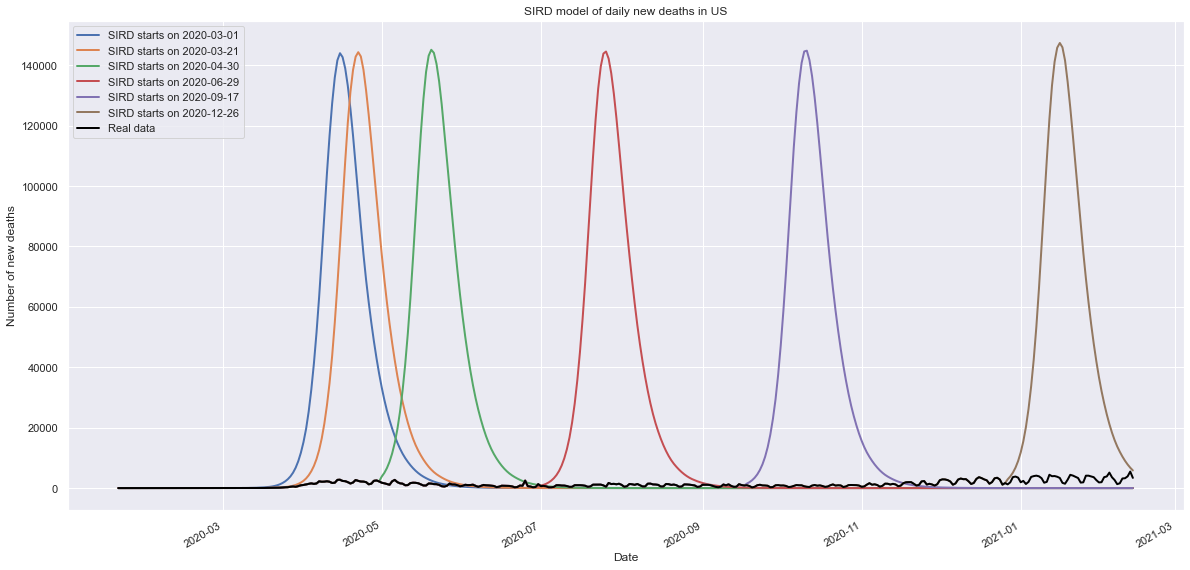

In [3]:
target = 40
R0 = 2.4   # Basic Reproductive Rate [people]
M = 0.01   # Mortality ratio [fraction]
P = 5     # Average infectious period [days] 
fig, ax = plt.subplots(figsize=(20, 10))
check = False
for x in range(6):
    if x == 5:
        check = True
    target += 20*x
    targetDate = dataUS[target]
    targetDatePre = dataUS[target-1]
    initial_conditions = {'population': 328239523, 'deaths': [targetDatePre[1],targetDate[1]]}
    sird = SIRD(R0, M, P)
    sird.solve(initial_conditions, tf = len(dataUS)-target)
    sird.plot(dataUS, targetDate[0], fig=fig, ax=ax, check=check, name="US")
plt.show()


### Step 3.2: Plot the line charts of states' daily new deaths


SIRD simulation starts on 2020-04-02 in Alabama:
For a population of 4903185 people, after 318 days there were:
0.9% total deaths, or 42316 people.
86.3% total recovered, or 4231580 people.
At the virus' maximum 21.9% people were simultaneously infected, or 1073188 people.
After 318 days the virus was present in less than 3 individuals.

SIRD simulation starts on 2020-05-12 in Alabama:
For a population of 4903185 people, after 278 days there were:
0.9% total deaths, or 42761 people.
87.2% total recovered, or 4276104 people.
At the virus' maximum 22.9% people were simultaneously infected, or 1121417 people.
After 278 days the virus was present in less than 2 individuals.

SIRD simulation starts on 2020-06-21 in Alabama:
For a population of 4903185 people, after 238 days there were:
0.9% total deaths, or 43050 people.
87.8% total recovered, or 4305026 people.
At the virus' maximum 23.8% people were simultaneously infected, or 1168521 people.
After 238 days the virus was present in less t

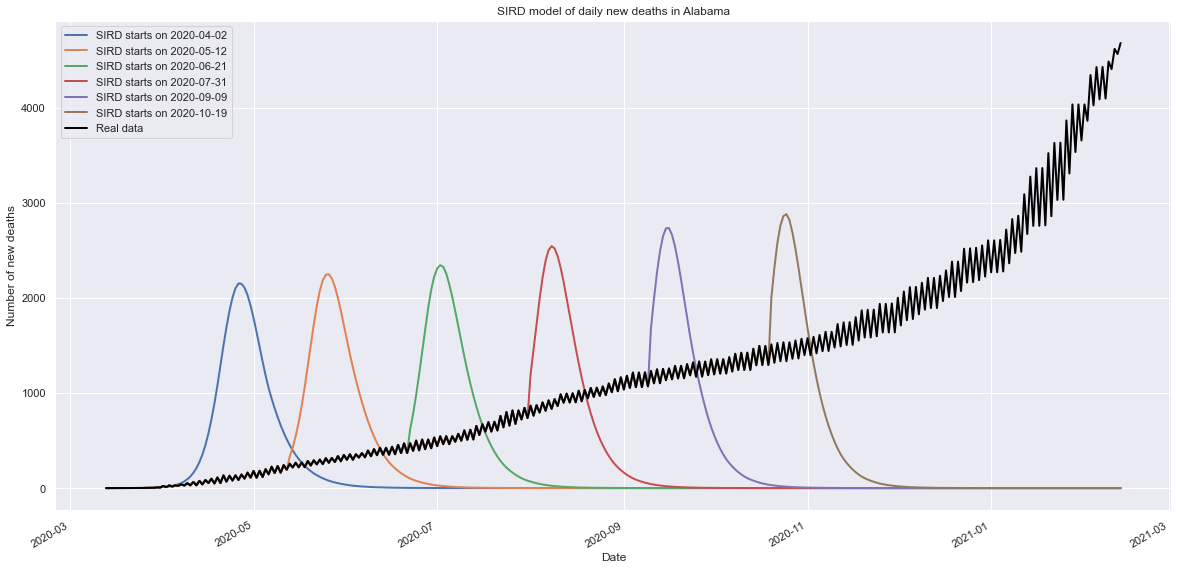

SIRD simulation starts on 2020-04-01 in Alaska:
For a population of 731545 people, after 319 days there were:
0.9% total deaths, or 6357 people.
86.9% total recovered, or 635687 people.
At the virus' maximum 21.8% people were simultaneously infected, or 159714 people.
After 319 days the virus was present in less than 0 individuals.

SIRD simulation starts on 2020-05-11 in Alaska:
For a population of 731545 people, after 279 days there were:
0.9% total deaths, or 6363 people.
87.0% total recovered, or 636287 people.
At the virus' maximum 22.0% people were simultaneously infected, or 160786 people.
After 279 days the virus was present in less than 0 individuals.

SIRD simulation starts on 2020-06-20 in Alaska:
For a population of 731545 people, after 239 days there were:
0.9% total deaths, or 6372 people.
87.1% total recovered, or 637162 people.
At the virus' maximum 22.0% people were simultaneously infected, or 161132 people.
After 239 days the virus was present in less than 0 individua

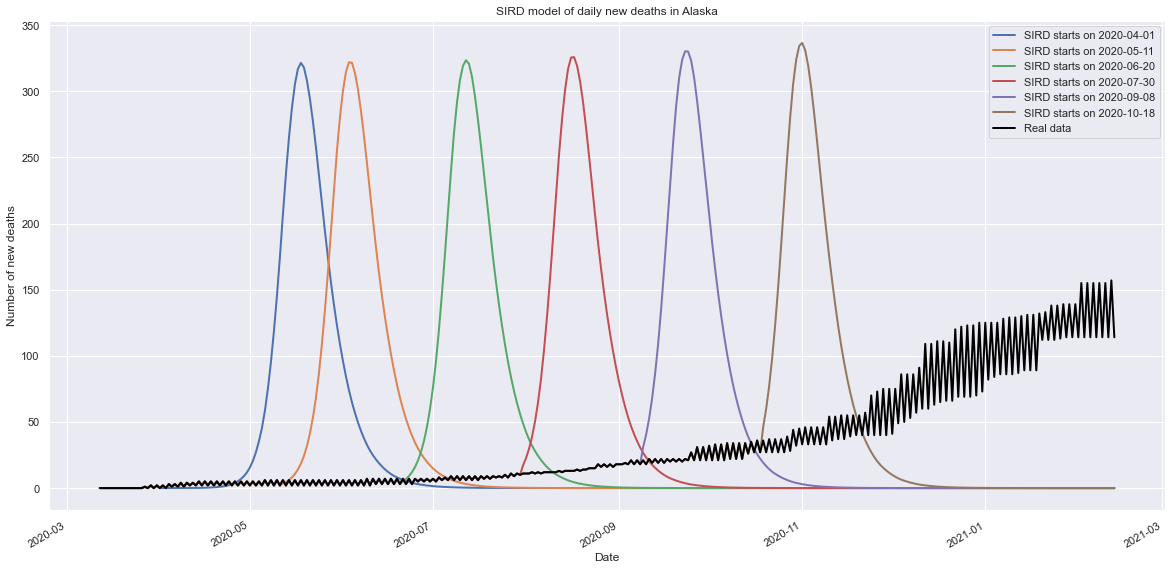

SIRD simulation starts on 2020-02-15 in Arizona:
For a population of 7278717 people, after 365 days there were:
0.0% total deaths, or 0 people.
0.0% total recovered, or 0 people.
At the virus' maximum 0.0% people were simultaneously infected, or 0 people.
After 365 days the virus was present in less than 0 individuals.

SIRD simulation starts on 2020-03-26 in Arizona:
For a population of 7278717 people, after 325 days there were:
0.9% total deaths, or 63346 people.
87.0% total recovered, or 6334647 people.
At the virus' maximum 21.9% people were simultaneously infected, or 1596370 people.
After 325 days the virus was present in less than 2 individuals.

SIRD simulation starts on 2020-05-05 in Arizona:
For a population of 7278717 people, after 285 days there were:
0.9% total deaths, or 63595 people.
87.4% total recovered, or 6359538 people.
At the virus' maximum 22.6% people were simultaneously infected, or 1648191 people.
After 285 days the virus was present in less than 1 individuals.

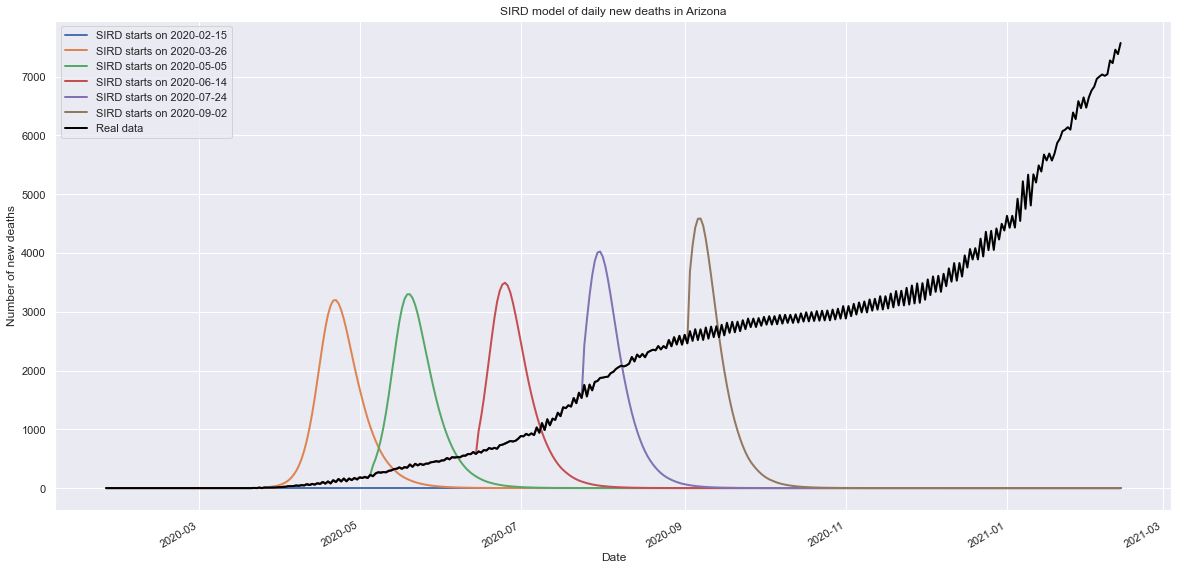

SIRD simulation starts on 2020-03-31 in Arkansas:
For a population of 3017804 people, after 320 days there were:
0.9% total deaths, or 26280 people.
87.1% total recovered, or 2628001 people.
At the virus' maximum 21.9% people were simultaneously infected, or 661841 people.
After 320 days the virus was present in less than 1 individuals.

SIRD simulation starts on 2020-05-10 in Arkansas:
For a population of 3017804 people, after 280 days there were:
0.9% total deaths, or 26308 people.
87.2% total recovered, or 2630840 people.
At the virus' maximum 22.4% people were simultaneously infected, or 674497 people.
After 280 days the virus was present in less than 1 individuals.

SIRD simulation starts on 2020-06-19 in Arkansas:
For a population of 3017804 people, after 240 days there were:
0.9% total deaths, or 26356 people.
87.3% total recovered, or 2635621 people.
At the virus' maximum 22.8% people were simultaneously infected, or 687191 people.
After 240 days the virus was present in less t

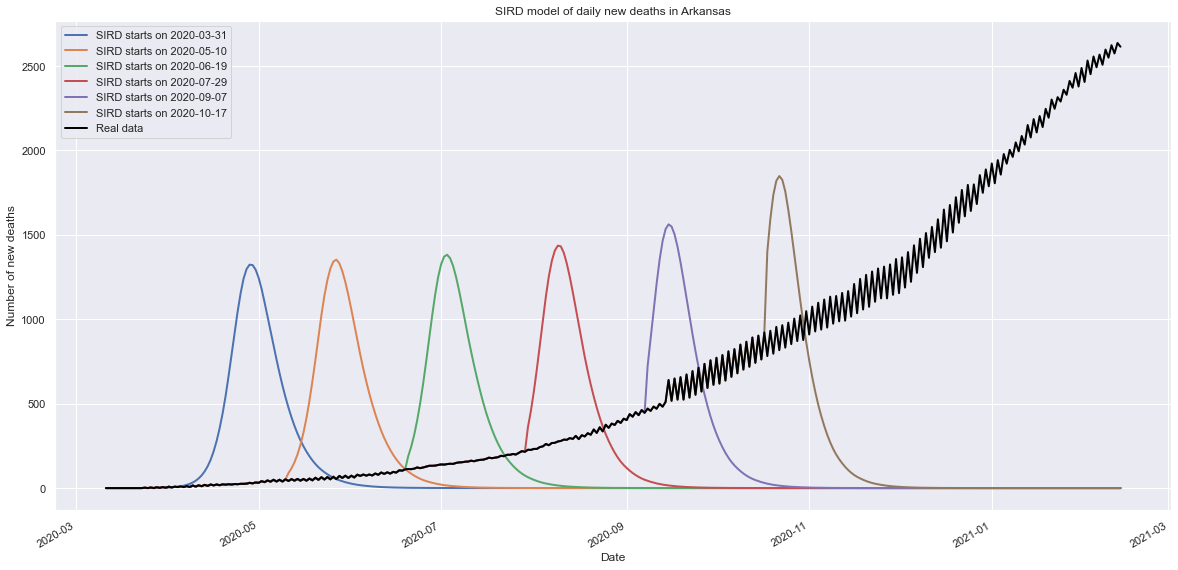

SIRD simulation starts on 2020-02-14 in California:
For a population of 39512223 people, after 366 days there were:
0.0% total deaths, or 0 people.
0.0% total recovered, or 0 people.
At the virus' maximum 0.0% people were simultaneously infected, or 0 people.
After 366 days the virus was present in less than 0 individuals.

SIRD simulation starts on 2020-03-25 in California:
For a population of 39512223 people, after 326 days there were:
0.9% total deaths, or 344030 people.
87.1% total recovered, or 34402961 people.
At the virus' maximum 21.9% people were simultaneously infected, or 8663020 people.
After 326 days the virus was present in less than 7 individuals.

SIRD simulation starts on 2020-05-04 in California:
For a population of 39512223 people, after 286 days there were:
0.9% total deaths, or 345198 people.
87.4% total recovered, or 34519802 people.
At the virus' maximum 22.6% people were simultaneously infected, or 8925949 people.
After 286 days the virus was present in less tha

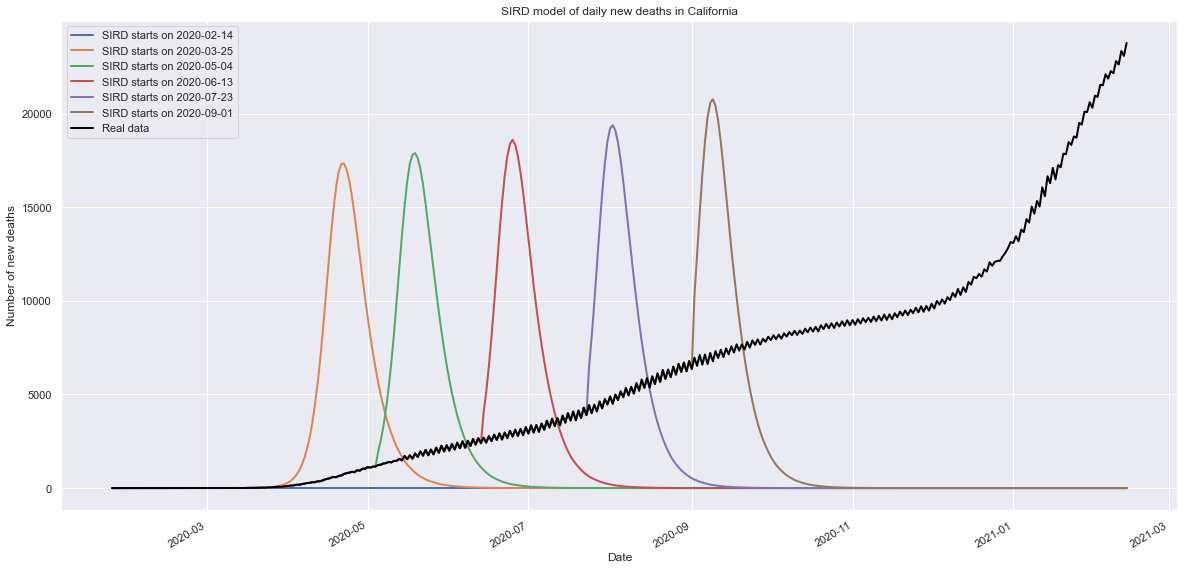

SIRD simulation starts on 2020-03-25 in Colorado:
For a population of 5758736 people, after 326 days there were:
0.9% total deaths, or 50092 people.
87.0% total recovered, or 5009236 people.
At the virus' maximum 22.0% people were simultaneously infected, or 1265903 people.
After 326 days the virus was present in less than 2 individuals.

SIRD simulation starts on 2020-05-04 in Colorado:
For a population of 5758736 people, after 286 days there were:
0.9% total deaths, or 50586 people.
87.8% total recovered, or 5058635 people.
At the virus' maximum 23.9% people were simultaneously infected, or 1375868 people.
After 286 days the virus was present in less than 6 individuals.

SIRD simulation starts on 2020-06-13 in Colorado:
For a population of 5758736 people, after 246 days there were:
0.9% total deaths, or 50851 people.
88.3% total recovered, or 5085145 people.
At the virus' maximum 25.4% people were simultaneously infected, or 1462409 people.
After 246 days the virus was present in les

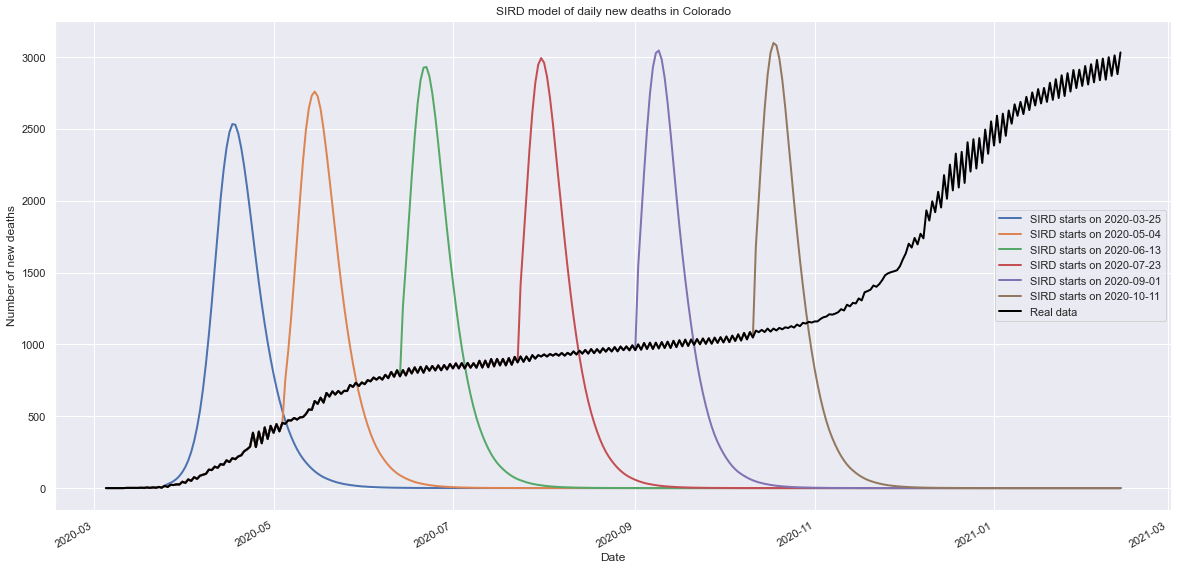

SIRD simulation starts on 2020-03-28 in Connecticut:
For a population of 3565287 people, after 323 days there were:
0.9% total deaths, or 31050 people.
87.1% total recovered, or 3105013 people.
At the virus' maximum 22.1% people were simultaneously infected, or 786265 people.
After 323 days the virus was present in less than 2 individuals.

SIRD simulation starts on 2020-05-07 in Connecticut:
For a population of 3565287 people, after 283 days there were:
0.9% total deaths, or 32215 people.
90.4% total recovered, or 3221544 people.
At the virus' maximum 32.1% people were simultaneously infected, or 1145141 people.
After 283 days the virus was present in less than 0 individuals.

SIRD simulation starts on 2020-06-16 in Connecticut:
For a population of 3565287 people, after 243 days there were:
0.9% total deaths, or 32805 people.
92.0% total recovered, or 3280489 people.
At the virus' maximum 39.1% people were simultaneously infected, or 1395426 people.
After 243 days the virus was presen

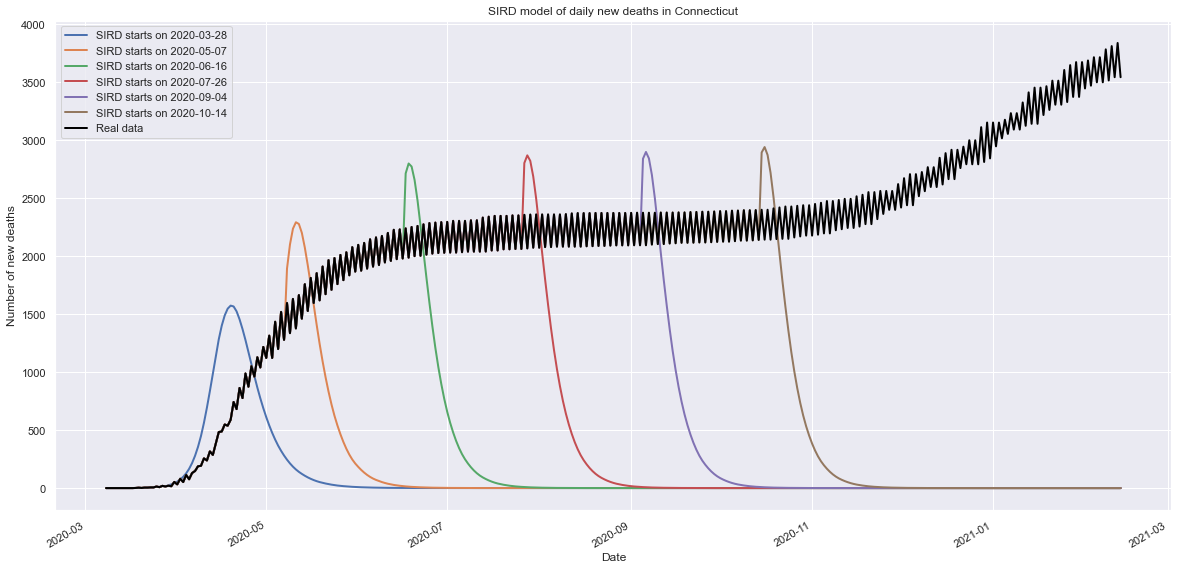

SIRD simulation starts on 2020-03-31 in Delaware:
For a population of 973764 people, after 320 days there were:
0.9% total deaths, or 8484 people.
87.1% total recovered, or 848424 people.
At the virus' maximum 22.1% people were simultaneously infected, or 214786 people.
After 320 days the virus was present in less than 0 individuals.

SIRD simulation starts on 2020-05-10 in Delaware:
For a population of 973764 people, after 280 days there were:
0.9% total deaths, or 8586 people.
88.2% total recovered, or 858564 people.
At the virus' maximum 24.9% people were simultaneously infected, or 242867 people.
After 280 days the virus was present in less than 0 individuals.

SIRD simulation starts on 2020-06-19 in Delaware:
For a population of 973764 people, after 240 days there were:
0.9% total deaths, or 8690 people.
89.2% total recovered, or 868967 people.
At the virus' maximum 28.2% people were simultaneously infected, or 274200 people.
After 240 days the virus was present in less than 1 ind

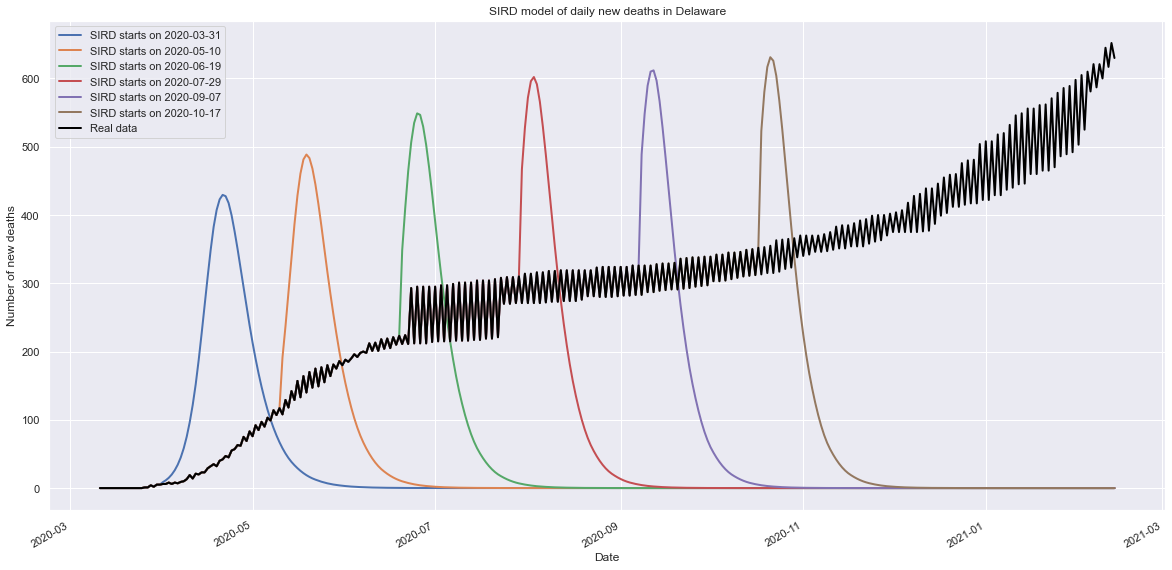

SIRD simulation starts on 2020-03-27 in District of Columbia:
For a population of 705749 people, after 324 days there were:
0.9% total deaths, or 6140 people.
87.0% total recovered, or 613964 people.
At the virus' maximum 22.0% people were simultaneously infected, or 155159 people.
After 324 days the virus was present in less than 0 individuals.

SIRD simulation starts on 2020-05-06 in District of Columbia:
For a population of 705749 people, after 284 days there were:
0.9% total deaths, or 6294 people.
89.2% total recovered, or 629410 people.
At the virus' maximum 28.0% people were simultaneously infected, or 197305 people.
After 284 days the virus was present in less than 1 individuals.

SIRD simulation starts on 2020-06-15 in District of Columbia:
For a population of 705749 people, after 244 days there were:
0.9% total deaths, or 6396 people.
90.6% total recovered, or 639644 people.
At the virus' maximum 33.1% people were simultaneously infected, or 233482 people.
After 244 days the 

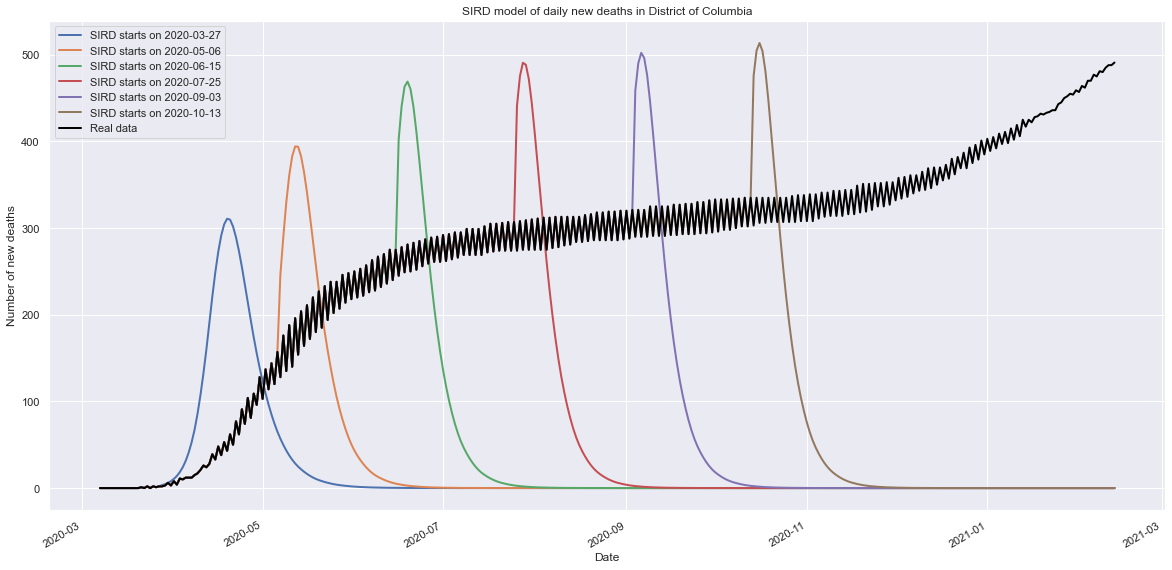

SIRD simulation starts on 2020-03-21 in Florida:
For a population of 21477737 people, after 330 days there were:
0.9% total deaths, or 187020 people.
87.1% total recovered, or 18702047 people.
At the virus' maximum 22.0% people were simultaneously infected, or 4720137 people.
After 330 days the virus was present in less than 7 individuals.

SIRD simulation starts on 2020-04-30 in Florida:
For a population of 21477737 people, after 290 days there were:
0.9% total deaths, or 187660 people.
87.4% total recovered, or 18766004 people.
At the virus' maximum 22.7% people were simultaneously infected, or 4873446 people.
After 290 days the virus was present in less than 5 individuals.

SIRD simulation starts on 2020-06-09 in Florida:
For a population of 21477737 people, after 250 days there were:
0.9% total deaths, or 188316 people.
87.7% total recovered, or 18831643 people.
At the virus' maximum 23.6% people were simultaneously infected, or 5077079 people.
After 250 days the virus was present 

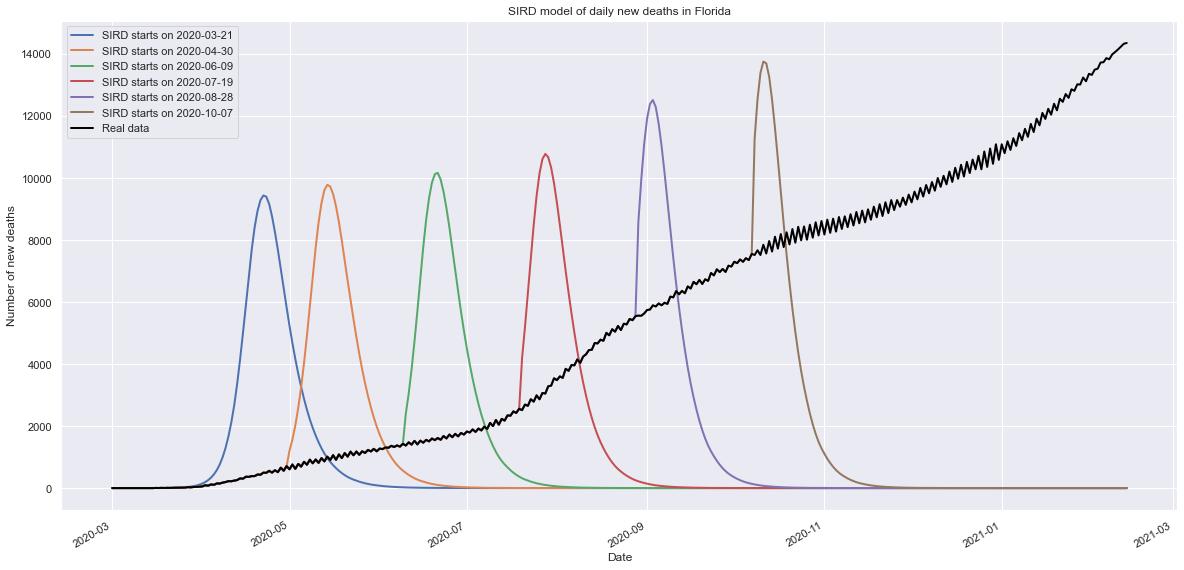

SIRD simulation starts on 2020-03-22 in Georgia:
For a population of 10617423 people, after 329 days there were:
0.9% total deaths, or 92395 people.
87.0% total recovered, or 9239512 people.
At the virus' maximum 21.9% people were simultaneously infected, or 2329142 people.
After 329 days the virus was present in less than 1 individuals.

SIRD simulation starts on 2020-05-01 in Georgia:
For a population of 10617423 people, after 289 days there were:
0.9% total deaths, or 93012 people.
87.6% total recovered, or 9301173 people.
At the virus' maximum 23.4% people were simultaneously infected, or 2485402 people.
After 289 days the virus was present in less than 7 individuals.

SIRD simulation starts on 2020-06-10 in Georgia:
For a population of 10617423 people, after 249 days there were:
0.9% total deaths, or 93545 people.
88.1% total recovered, or 9354524 people.
At the virus' maximum 24.8% people were simultaneously infected, or 2628163 people.
After 249 days the virus was present in les

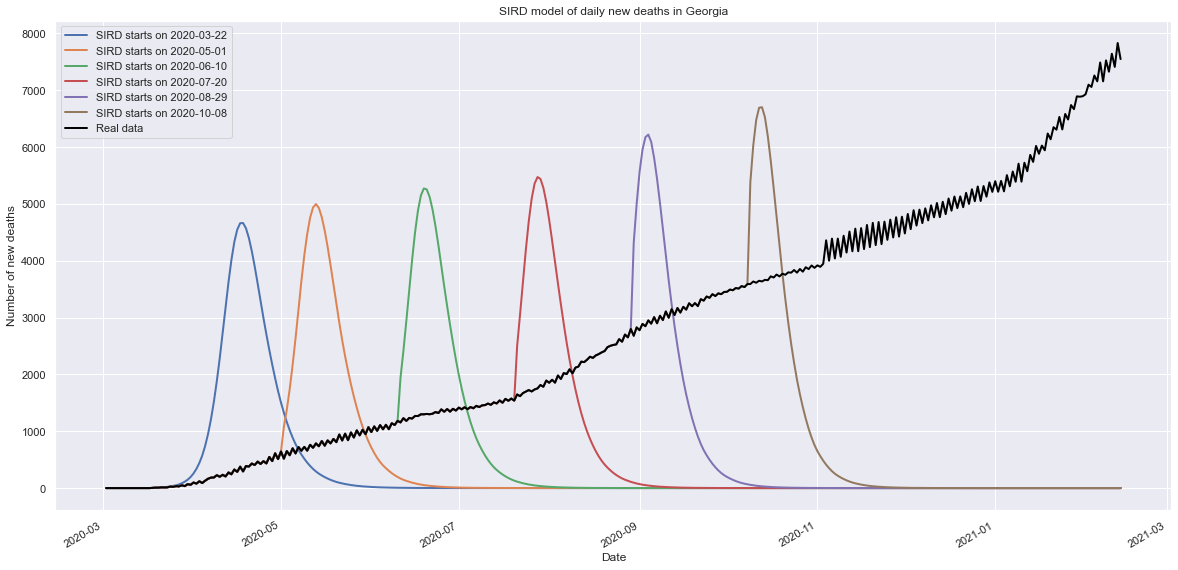

SIRD simulation starts on 2020-03-26 in Hawaii:
For a population of 1415872 people, after 325 days there were:
0.0% total deaths, or 0 people.
0.0% total recovered, or 0 people.
At the virus' maximum 0.0% people were simultaneously infected, or 0 people.
After 325 days the virus was present in less than 0 individuals.

SIRD simulation starts on 2020-05-05 in Hawaii:
For a population of 1415872 people, after 285 days there were:
0.9% total deaths, or 12337 people.
87.1% total recovered, or 1233707 people.
At the virus' maximum 22.0% people were simultaneously infected, or 311699 people.
After 285 days the virus was present in less than 1 individuals.

SIRD simulation starts on 2020-06-14 in Hawaii:
For a population of 1415872 people, after 245 days there were:
0.9% total deaths, or 12337 people.
87.1% total recovered, or 1233707 people.
At the virus' maximum 22.0% people were simultaneously infected, or 311665 people.
After 245 days the virus was present in less than 1 individuals.

SIR

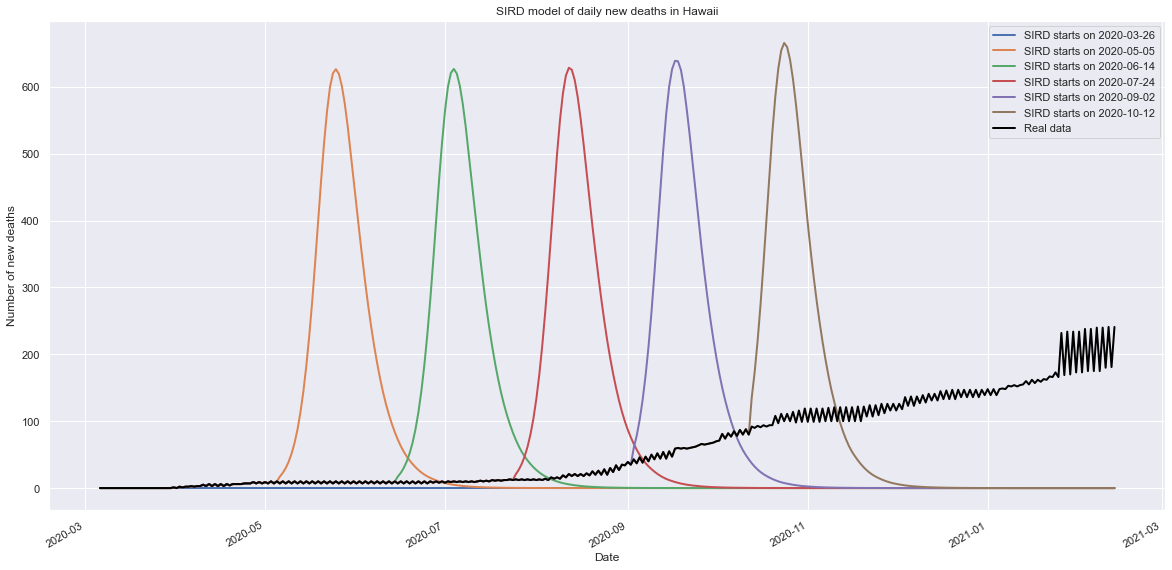

SIRD simulation starts on 2020-04-02 in Idaho:
For a population of 1787065 people, after 318 days there were:
0.9% total deaths, or 15505 people.
86.8% total recovered, or 1550503 people.
At the virus' maximum 21.9% people were simultaneously infected, or 390979 people.
After 318 days the virus was present in less than 1 individuals.

SIRD simulation starts on 2020-05-12 in Idaho:
For a population of 1787065 people, after 278 days there were:
0.9% total deaths, or 15583 people.
87.2% total recovered, or 1558256 people.
At the virus' maximum 22.4% people were simultaneously infected, or 400162 people.
After 278 days the virus was present in less than 1 individuals.

SIRD simulation starts on 2020-06-21 in Idaho:
For a population of 1787065 people, after 238 days there were:
0.9% total deaths, or 15606 people.
87.3% total recovered, or 1560580 people.
At the virus' maximum 22.6% people were simultaneously infected, or 402994 people.
After 238 days the virus was present in less than 0 ind

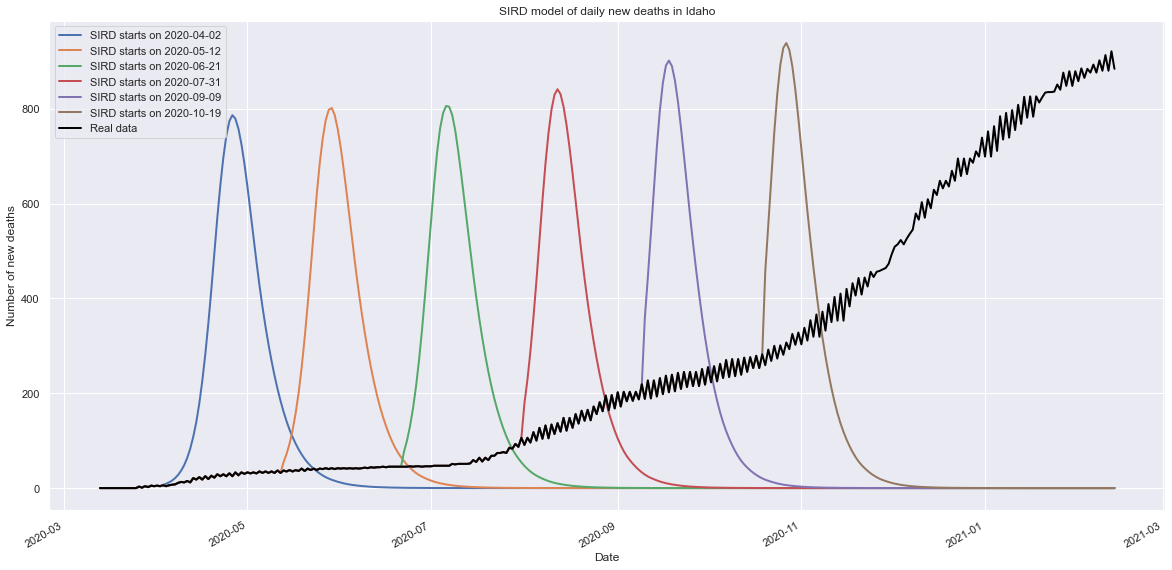

SIRD simulation starts on 2020-02-13 in Illinois:
For a population of 12671821 people, after 367 days there were:
0.0% total deaths, or 0 people.
0.0% total recovered, or 0 people.
At the virus' maximum 0.0% people were simultaneously infected, or 0 people.
After 367 days the virus was present in less than 0 individuals.

SIRD simulation starts on 2020-03-24 in Illinois:
For a population of 12671821 people, after 327 days there were:
0.9% total deaths, or 110352 people.
87.1% total recovered, or 11035241 people.
At the virus' maximum 21.9% people were simultaneously infected, or 2778385 people.
After 327 days the virus was present in less than 5 individuals.

SIRD simulation starts on 2020-05-03 in Illinois:
For a population of 12671821 people, after 287 days there were:
0.9% total deaths, or 111522 people.
88.0% total recovered, or 11152208 people.
At the virus' maximum 24.3% people were simultaneously infected, or 3085183 people.
After 287 days the virus was present in less than 9 in

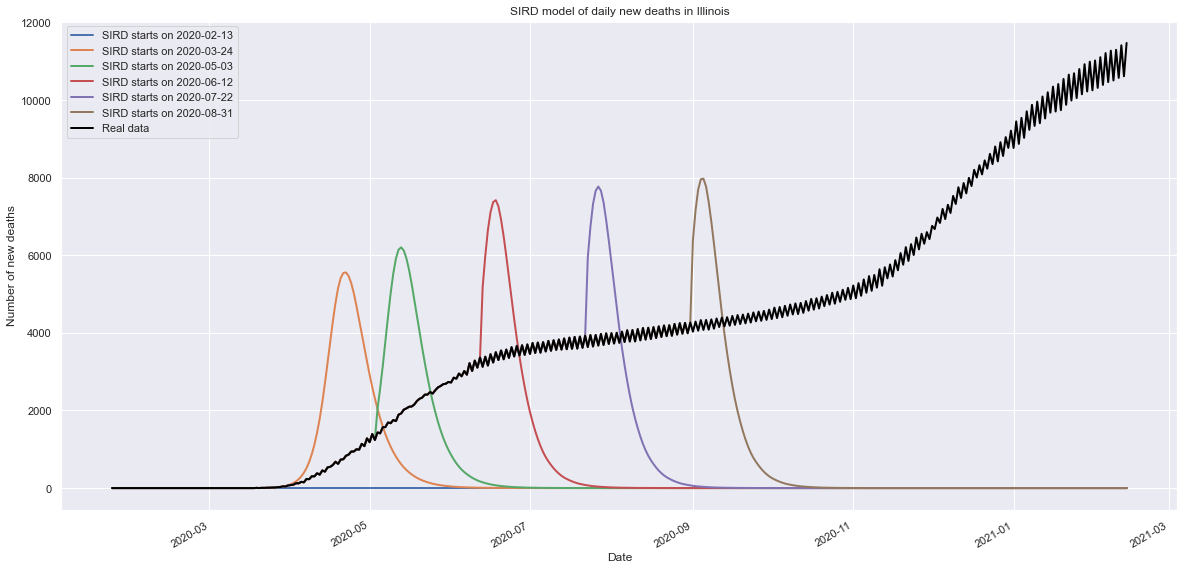

SIRD simulation starts on 2020-03-26 in Indiana:
For a population of 6732219 people, after 325 days there were:
0.9% total deaths, or 58479 people.
86.9% total recovered, or 5847916 people.
At the virus' maximum 21.9% people were simultaneously infected, or 1473066 people.
After 325 days the virus was present in less than 1 individuals.

SIRD simulation starts on 2020-05-05 in Indiana:
For a population of 6732219 people, after 285 days there were:
0.9% total deaths, or 59281 people.
88.1% total recovered, or 5928131 people.
At the virus' maximum 24.6% people were simultaneously infected, or 1655266 people.
After 285 days the virus was present in less than 4 individuals.

SIRD simulation starts on 2020-06-14 in Indiana:
For a population of 6732219 people, after 245 days there were:
0.9% total deaths, or 59801 people.
88.8% total recovered, or 5980110 people.
At the virus' maximum 27.0% people were simultaneously infected, or 1815857 people.
After 245 days the virus was present in less t

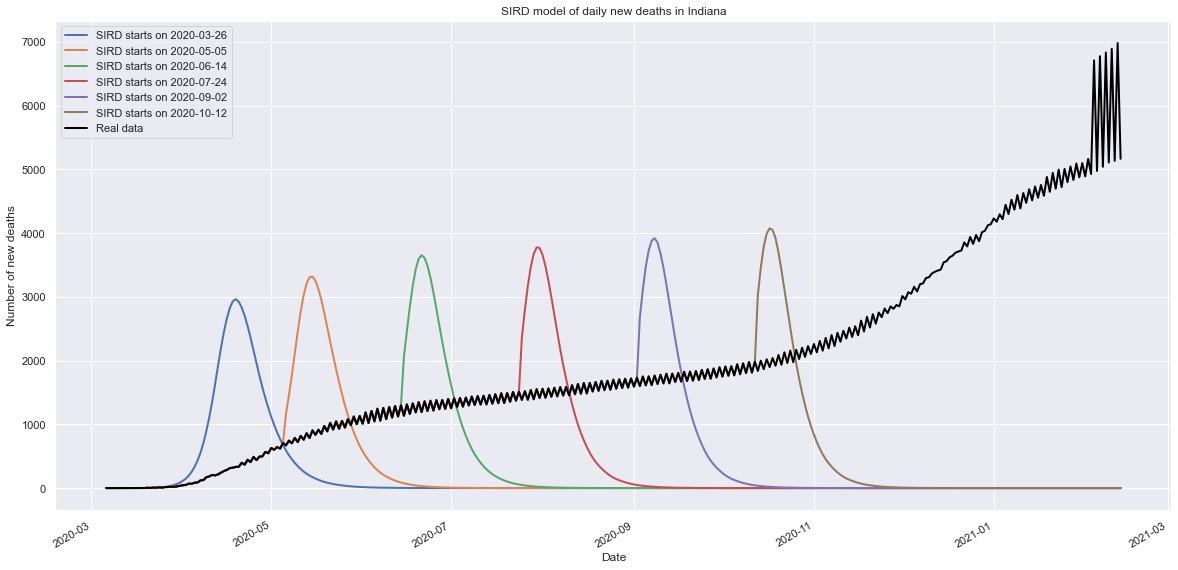

SIRD simulation starts on 2020-03-28 in Iowa:
For a population of 3155070 people, after 323 days there were:
0.9% total deaths, or 27475 people.
87.1% total recovered, or 2747500 people.
At the virus' maximum 22.0% people were simultaneously infected, or 692643 people.
After 323 days the virus was present in less than 2 individuals.

SIRD simulation starts on 2020-05-07 in Iowa:
For a population of 3155070 people, after 283 days there were:
0.9% total deaths, or 27539 people.
87.3% total recovered, or 2753898 people.
At the virus' maximum 22.8% people were simultaneously infected, or 720371 people.
After 283 days the virus was present in less than 2 individuals.

SIRD simulation starts on 2020-06-16 in Iowa:
For a population of 3155070 people, after 243 days there were:
0.9% total deaths, or 27774 people.
88.0% total recovered, or 2777440 people.
At the virus' maximum 24.5% people were simultaneously infected, or 772271 people.
After 243 days the virus was present in less than 4 indivi

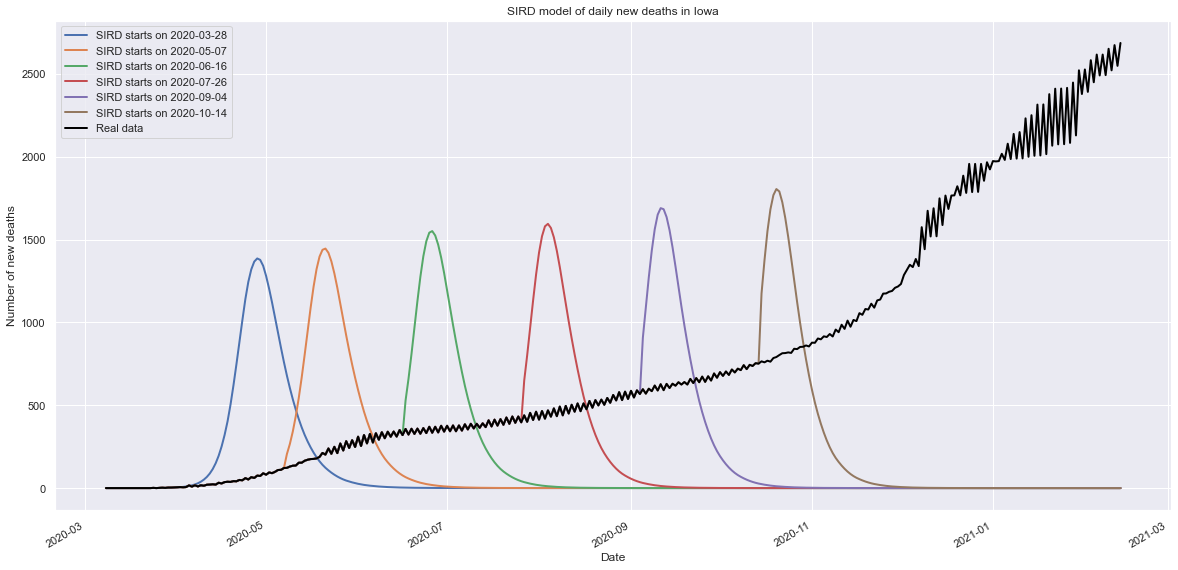

SIRD simulation starts on 2020-03-27 in Kansas:
For a population of 2913314 people, after 324 days there were:
0.9% total deaths, or 25370 people.
87.1% total recovered, or 2536964 people.
At the virus' maximum 21.9% people were simultaneously infected, or 638786 people.
After 324 days the virus was present in less than 1 individuals.

SIRD simulation starts on 2020-05-06 in Kansas:
For a population of 2913314 people, after 284 days there were:
0.9% total deaths, or 25446 people.
87.3% total recovered, or 2544621 people.
At the virus' maximum 22.5% people were simultaneously infected, or 656942 people.
After 284 days the virus was present in less than 1 individuals.

SIRD simulation starts on 2020-06-15 in Kansas:
For a population of 2913314 people, after 244 days there were:
0.9% total deaths, or 25417 people.
87.2% total recovered, or 2541655 people.
At the virus' maximum 22.9% people were simultaneously infected, or 665945 people.
After 244 days the virus was present in less than 1 

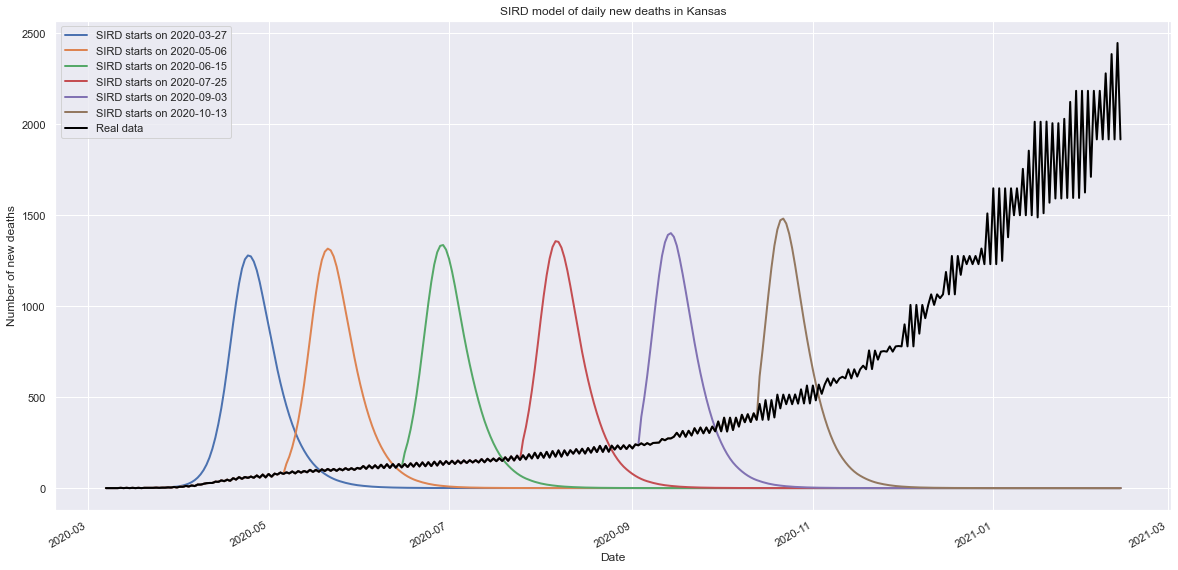

SIRD simulation starts on 2020-03-26 in Kentucky:
For a population of 4467673 people, after 325 days there were:
0.9% total deaths, or 38903 people.
87.1% total recovered, or 3890263 people.
At the virus' maximum 22.0% people were simultaneously infected, or 982328 people.
After 325 days the virus was present in less than 2 individuals.

SIRD simulation starts on 2020-05-05 in Kentucky:
For a population of 4467673 people, after 285 days there were:
0.9% total deaths, or 39033 people.
87.4% total recovered, or 3903253 people.
At the virus' maximum 22.6% people were simultaneously infected, or 1009835 people.
After 285 days the virus was present in less than 1 individuals.

SIRD simulation starts on 2020-06-14 in Kentucky:
For a population of 4467673 people, after 245 days there were:
0.9% total deaths, or 39137 people.
87.6% total recovered, or 3913742 people.
At the virus' maximum 23.4% people were simultaneously infected, or 1045667 people.
After 245 days the virus was present in less

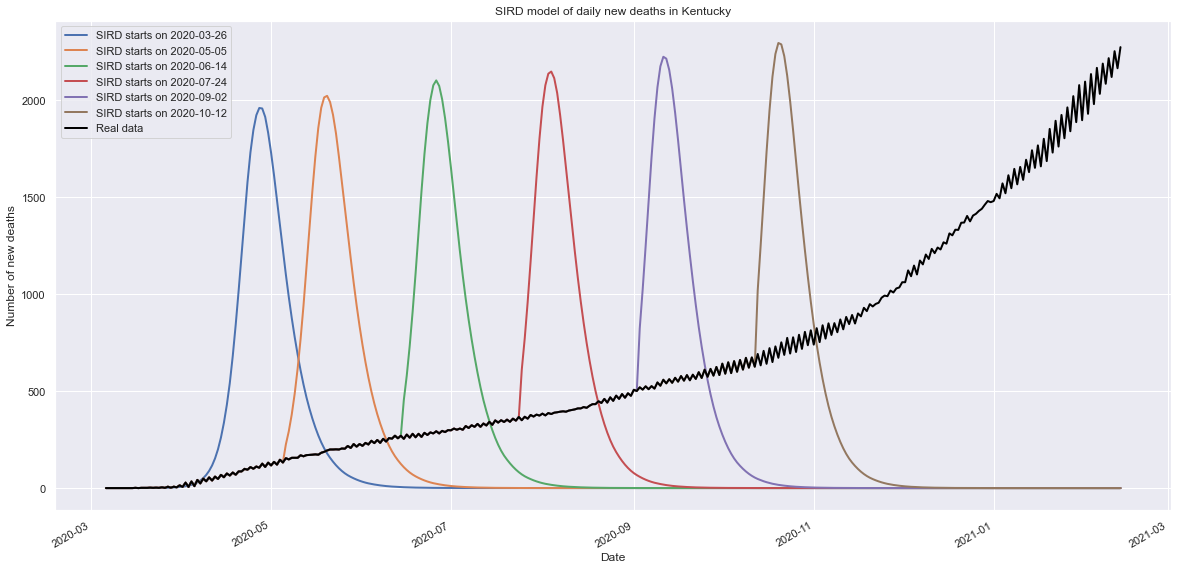

SIRD simulation starts on 2020-03-29 in Louisiana:
For a population of 4648794 people, after 322 days there were:
0.9% total deaths, or 40565 people.
87.3% total recovered, or 4056550 people.
At the virus' maximum 22.5% people were simultaneously infected, or 1043686 people.
After 322 days the virus was present in less than 3 individuals.

SIRD simulation starts on 2020-05-08 in Louisiana:
For a population of 4648794 people, after 282 days there were:
0.9% total deaths, or 41582 people.
89.4% total recovered, or 4158208 people.
At the virus' maximum 28.8% people were simultaneously infected, or 1337366 people.
After 282 days the virus was present in less than 5 individuals.

SIRD simulation starts on 2020-06-17 in Louisiana:
For a population of 4648794 people, after 242 days there were:
0.9% total deaths, or 41981 people.
90.3% total recovered, or 4198071 people.
At the virus' maximum 31.9% people were simultaneously infected, or 1484025 people.
After 242 days the virus was present in 

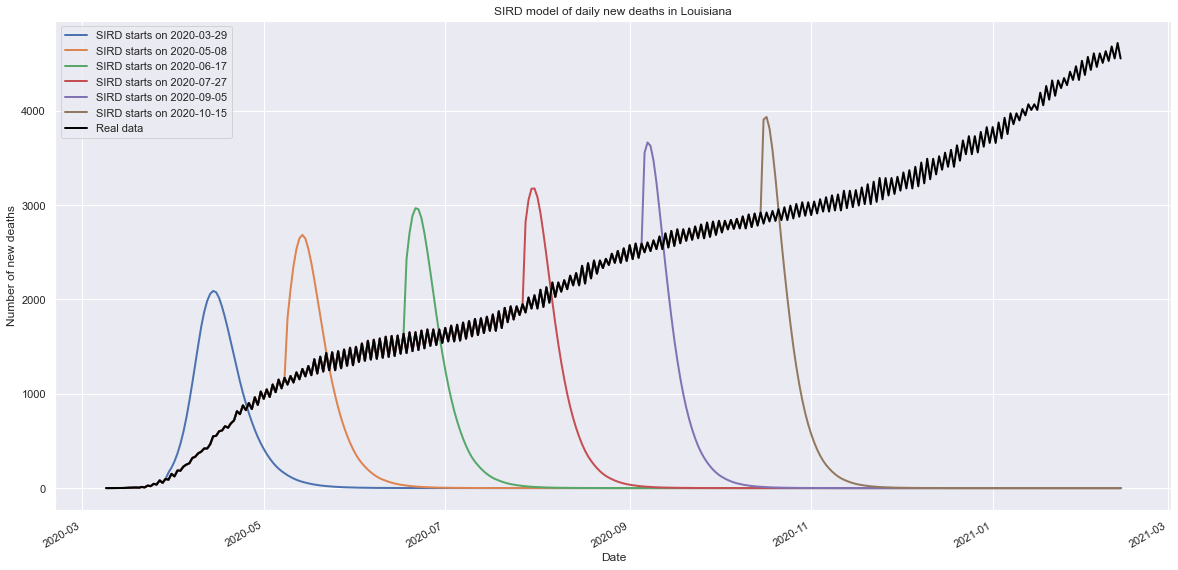

SIRD simulation starts on 2020-04-01 in Maine:
For a population of 1344212 people, after 319 days there were:
0.9% total deaths, or 11670 people.
86.8% total recovered, or 1166993 people.
At the virus' maximum 21.9% people were simultaneously infected, or 294580 people.
After 319 days the virus was present in less than 0 individuals.

SIRD simulation starts on 2020-05-11 in Maine:
For a population of 1344212 people, after 279 days there were:
0.9% total deaths, or 11743 people.
87.4% total recovered, or 1174281 people.
At the virus' maximum 22.5% people were simultaneously infected, or 303065 people.
After 279 days the virus was present in less than 1 individuals.

SIRD simulation starts on 2020-06-20 in Maine:
For a population of 1344212 people, after 239 days there were:
0.9% total deaths, or 11735 people.
87.3% total recovered, or 1173516 people.
At the virus' maximum 22.8% people were simultaneously infected, or 306730 people.
After 239 days the virus was present in less than 1 ind

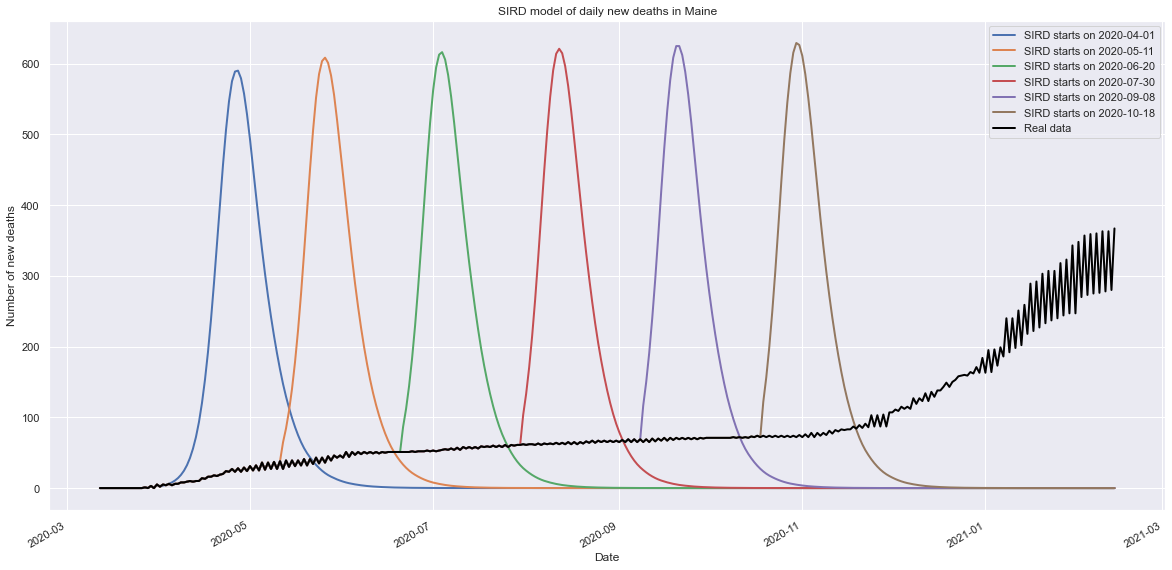

SIRD simulation starts on 2020-03-25 in Maryland:
For a population of 6045680 people, after 326 days there were:
0.9% total deaths, or 52641 people.
87.1% total recovered, or 5264105 people.
At the virus' maximum 22.0% people were simultaneously infected, or 1329739 people.
After 326 days the virus was present in less than 3 individuals.

SIRD simulation starts on 2020-05-04 in Maryland:
For a population of 6045680 people, after 286 days there were:
0.9% total deaths, or 53244 people.
88.1% total recovered, or 5324364 people.
At the virus' maximum 24.6% people were simultaneously infected, or 1489368 people.
After 286 days the virus was present in less than 4 individuals.

SIRD simulation starts on 2020-06-13 in Maryland:
For a population of 6045680 people, after 246 days there were:
0.9% total deaths, or 53992 people.
89.3% total recovered, or 5399194 people.
At the virus' maximum 28.4% people were simultaneously infected, or 1714636 people.
After 246 days the virus was present in les

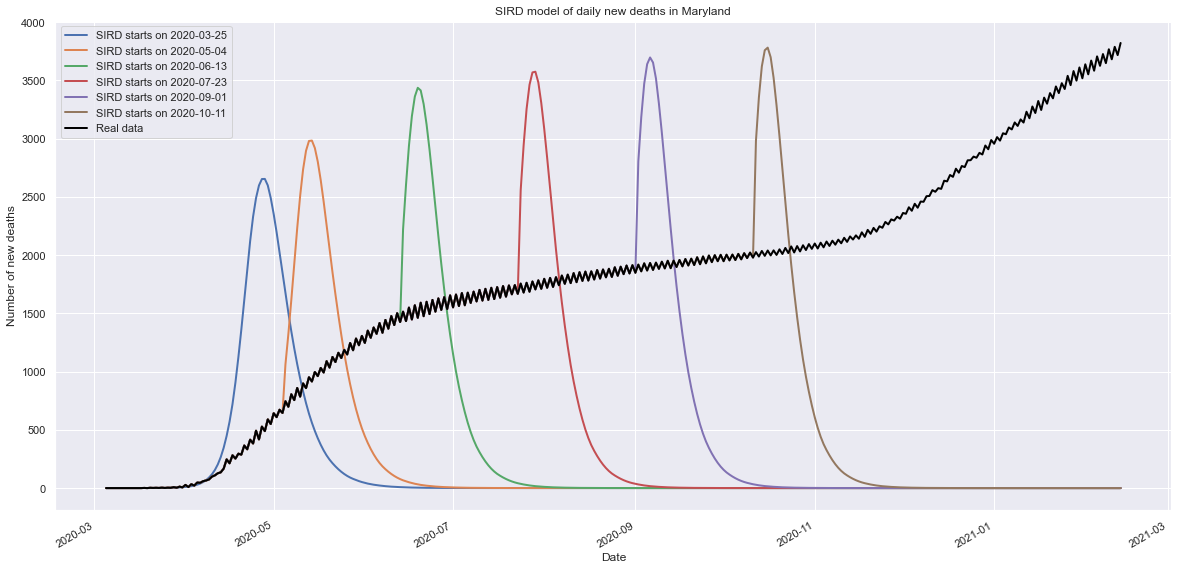

SIRD simulation starts on 2020-02-21 in Massachusetts:
For a population of 6892503 people, after 359 days there were:
0.0% total deaths, or 0 people.
0.0% total recovered, or 0 people.
At the virus' maximum 0.0% people were simultaneously infected, or 0 people.
After 359 days the virus was present in less than 0 individuals.

SIRD simulation starts on 2020-04-01 in Massachusetts:
For a population of 6892503 people, after 319 days there were:
0.9% total deaths, or 59962 people.
87.0% total recovered, or 5996157 people.
At the virus' maximum 22.1% people were simultaneously infected, or 1521985 people.
After 319 days the virus was present in less than 7 individuals.

SIRD simulation starts on 2020-05-11 in Massachusetts:
For a population of 6892503 people, after 279 days there were:
0.9% total deaths, or 62404 people.
90.5% total recovered, or 6240412 people.
At the virus' maximum 32.7% people were simultaneously infected, or 2252744 people.
After 279 days the virus was present in less t

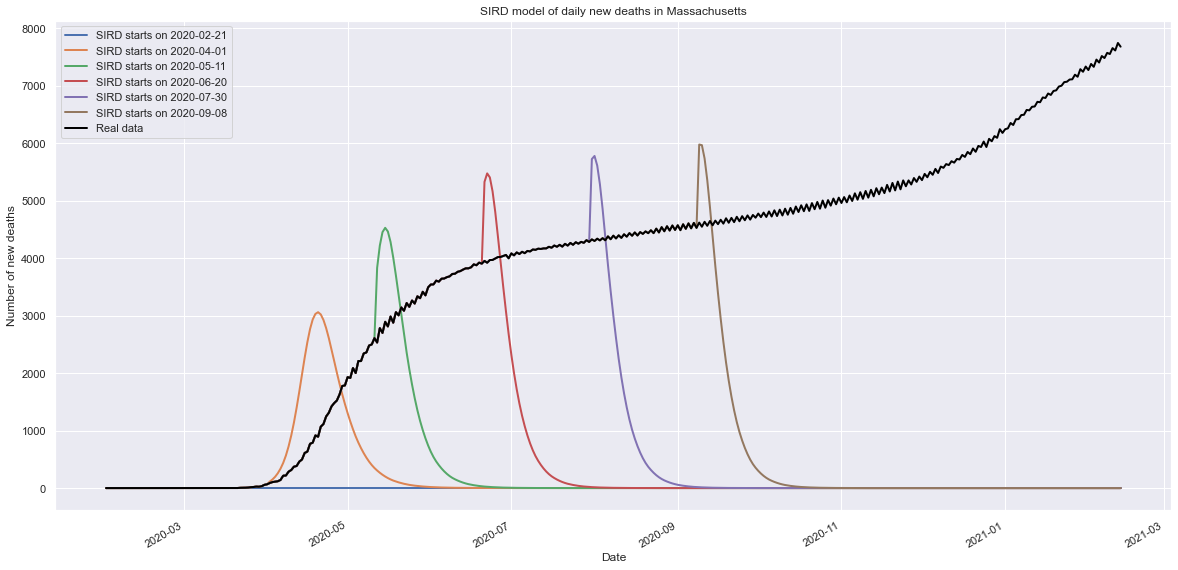

SIRD simulation starts on 2020-03-30 in Michigan:
For a population of 9986857 people, after 321 days there were:
0.9% total deaths, or 86951 people.
87.1% total recovered, or 8695057 people.
At the virus' maximum 22.1% people were simultaneously infected, or 2208020 people.
After 321 days the virus was present in less than 1 individuals.

SIRD simulation starts on 2020-05-09 in Michigan:
For a population of 9986857 people, after 281 days there were:
0.9% total deaths, or 89152 people.
89.3% total recovered, or 8915186 people.
At the virus' maximum 28.3% people were simultaneously infected, or 2821861 people.
After 281 days the virus was present in less than 5 individuals.

SIRD simulation starts on 2020-06-18 in Michigan:
For a population of 9986857 people, after 241 days there were:
0.9% total deaths, or 89811 people.
89.9% total recovered, or 8981054 people.
At the virus' maximum 30.3% people were simultaneously infected, or 3024303 people.
After 241 days the virus was present in les

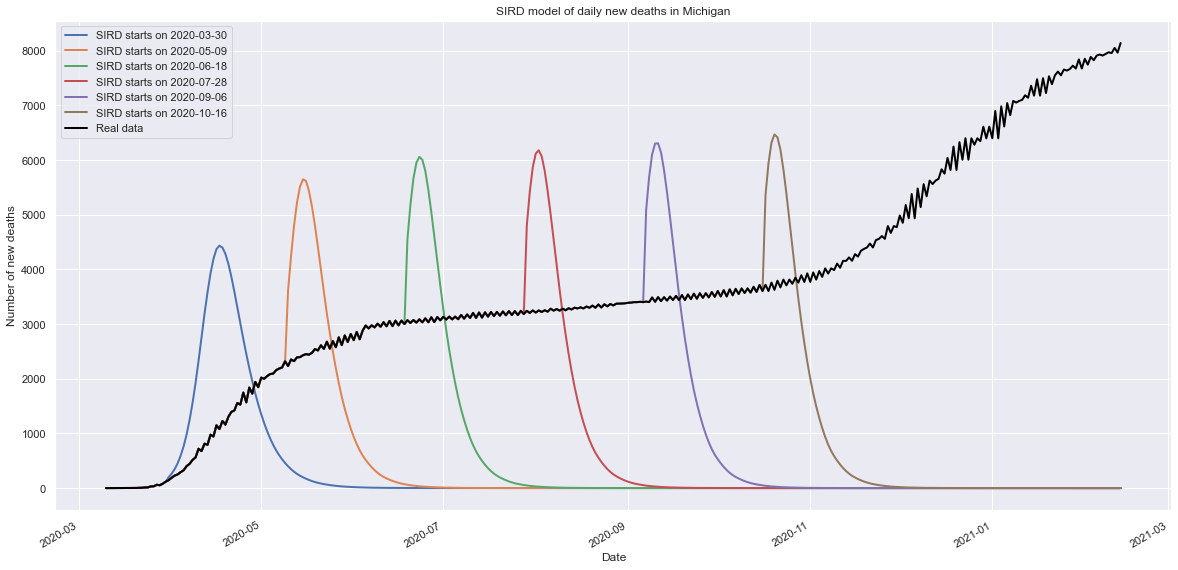

SIRD simulation starts on 2020-03-26 in Minnesota:
For a population of 5639632 people, after 325 days there were:
0.9% total deaths, or 49106 people.
87.1% total recovered, or 4910580 people.
At the virus' maximum 22.0% people were simultaneously infected, or 1239419 people.
After 325 days the virus was present in less than 3 individuals.

SIRD simulation starts on 2020-05-05 in Minnesota:
For a population of 5639632 people, after 285 days there were:
0.9% total deaths, or 49232 people.
87.3% total recovered, or 4923185 people.
At the virus' maximum 22.9% people were simultaneously infected, or 1293715 people.
After 285 days the virus was present in less than 2 individuals.

SIRD simulation starts on 2020-06-14 in Minnesota:
For a population of 5639632 people, after 245 days there were:
0.9% total deaths, or 49729 people.
88.2% total recovered, or 4972889 people.
At the virus' maximum 25.0% people were simultaneously infected, or 1408078 people.
After 245 days the virus was present in 

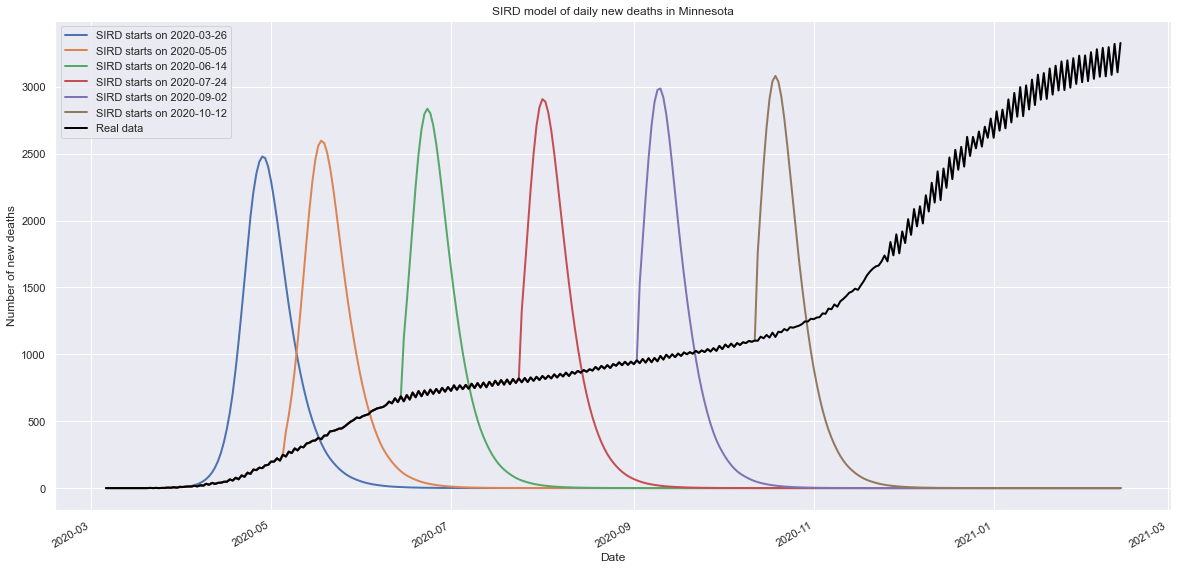

SIRD simulation starts on 2020-03-31 in Mississippi:
For a population of 2976149 people, after 320 days there were:
0.9% total deaths, or 25921 people.
87.1% total recovered, or 2592073 people.
At the virus' maximum 22.0% people were simultaneously infected, or 656009 people.
After 320 days the virus was present in less than 1 individuals.

SIRD simulation starts on 2020-05-10 in Mississippi:
For a population of 2976149 people, after 280 days there were:
0.9% total deaths, or 26107 people.
87.7% total recovered, or 2610673 people.
At the virus' maximum 23.7% people were simultaneously infected, or 705630 people.
After 280 days the virus was present in less than 1 individuals.

SIRD simulation starts on 2020-06-19 in Mississippi:
For a population of 2976149 people, after 240 days there were:
0.9% total deaths, or 26320 people.
88.4% total recovered, or 2632049 people.
At the virus' maximum 25.7% people were simultaneously infected, or 765616 people.
After 240 days the virus was present 

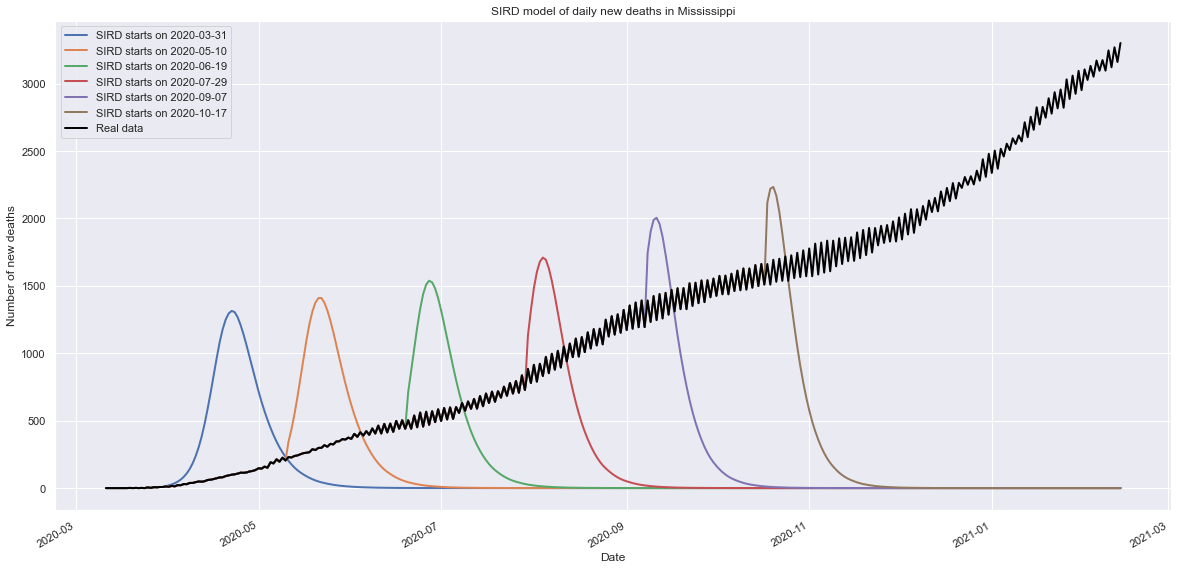

SIRD simulation starts on 2020-03-27 in Missouri:
For a population of 6137428 people, after 324 days there were:
0.9% total deaths, or 53439 people.
87.1% total recovered, or 5343932 people.
At the virus' maximum 21.9% people were simultaneously infected, or 1345117 people.
After 324 days the virus was present in less than 1 individuals.

SIRD simulation starts on 2020-05-06 in Missouri:
For a population of 6137428 people, after 284 days there were:
0.9% total deaths, or 53625 people.
87.4% total recovered, or 5362534 people.
At the virus' maximum 22.7% people were simultaneously infected, or 1392591 people.
After 284 days the virus was present in less than 3 individuals.

SIRD simulation starts on 2020-06-15 in Missouri:
For a population of 6137428 people, after 244 days there were:
0.9% total deaths, or 53861 people.
87.8% total recovered, or 5386071 people.
At the virus' maximum 23.8% people were simultaneously infected, or 1459279 people.
After 244 days the virus was present in les

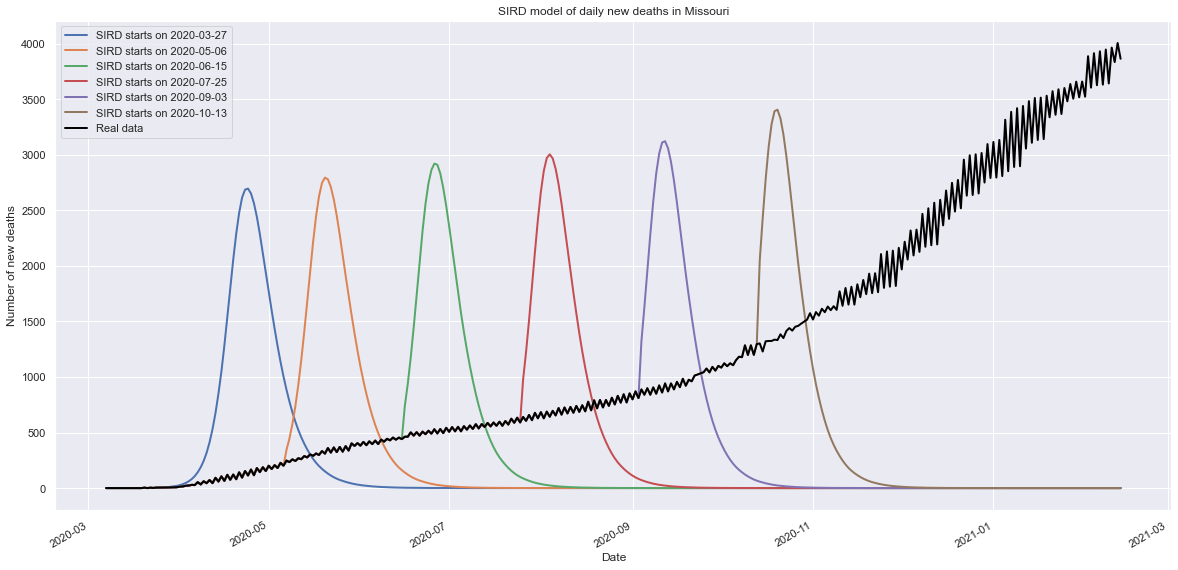

SIRD simulation starts on 2020-04-02 in Montana:
For a population of 1068778 people, after 318 days there were:
0.9% total deaths, or 9295 people.
87.0% total recovered, or 929524 people.
At the virus' maximum 21.9% people were simultaneously infected, or 233672 people.
After 318 days the virus was present in less than 1 individuals.

SIRD simulation starts on 2020-05-12 in Montana:
For a population of 1068778 people, after 278 days there were:
0.9% total deaths, or 9301 people.
87.0% total recovered, or 930111 people.
At the virus' maximum 22.1% people were simultaneously infected, or 235808 people.
After 278 days the virus was present in less than 1 individuals.

SIRD simulation starts on 2020-06-21 in Montana:
For a population of 1068778 people, after 238 days there were:
0.9% total deaths, or 9294 people.
87.0% total recovered, or 929418 people.
At the virus' maximum 22.1% people were simultaneously infected, or 236098 people.
After 238 days the virus was present in less than 1 ind

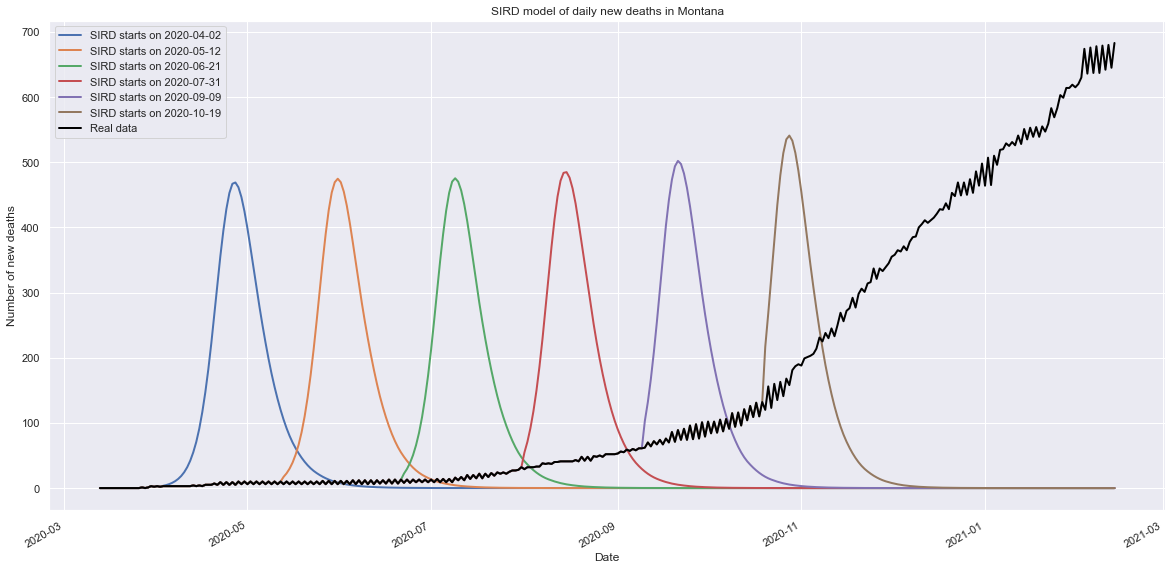

SIRD simulation starts on 2020-03-08 in Nebraska:
For a population of 1934408 people, after 343 days there were:
0.0% total deaths, or 0 people.
0.0% total recovered, or 0 people.
At the virus' maximum 0.0% people were simultaneously infected, or 0 people.
After 343 days the virus was present in less than 0 individuals.

SIRD simulation starts on 2020-04-17 in Nebraska:
For a population of 1934408 people, after 303 days there were:
0.9% total deaths, or 16844 people.
87.1% total recovered, or 1684355 people.
At the virus' maximum 22.1% people were simultaneously infected, or 426741 people.
After 303 days the virus was present in less than 2 individuals.

SIRD simulation starts on 2020-05-27 in Nebraska:
For a population of 1934408 people, after 263 days there were:
0.9% total deaths, or 16856 people.
87.1% total recovered, or 1685642 people.
At the virus' maximum 22.9% people were simultaneously infected, or 442812 people.
After 263 days the virus was present in less than 0 individuals

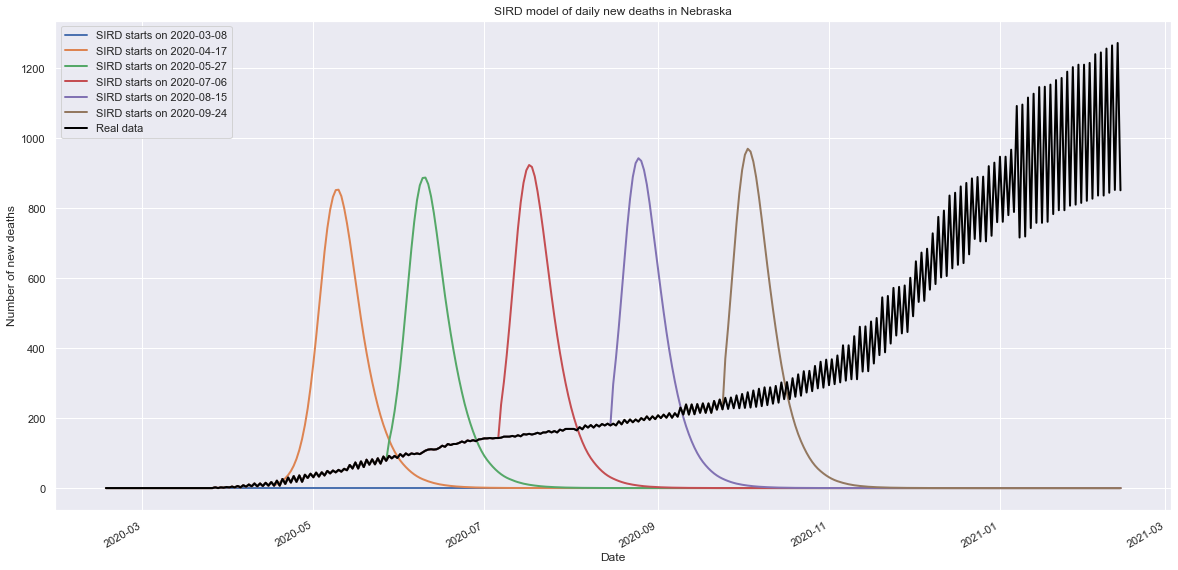

SIRD simulation starts on 2020-03-25 in Nevada:
For a population of 3080156 people, after 326 days there were:
0.9% total deaths, or 26770 people.
86.9% total recovered, or 2677017 people.
At the virus' maximum 21.9% people were simultaneously infected, or 673880 people.
After 326 days the virus was present in less than 1 individuals.

SIRD simulation starts on 2020-05-04 in Nevada:
For a population of 3080156 people, after 286 days there were:
0.9% total deaths, or 26884 people.
87.3% total recovered, or 2688431 people.
At the virus' maximum 23.0% people were simultaneously infected, or 707402 people.
After 286 days the virus was present in less than 1 individuals.

SIRD simulation starts on 2020-06-13 in Nevada:
For a population of 3080156 people, after 246 days there were:
0.9% total deaths, or 27067 people.
87.9% total recovered, or 2706728 people.
At the virus' maximum 24.0% people were simultaneously infected, or 738908 people.
After 246 days the virus was present in less than 1 

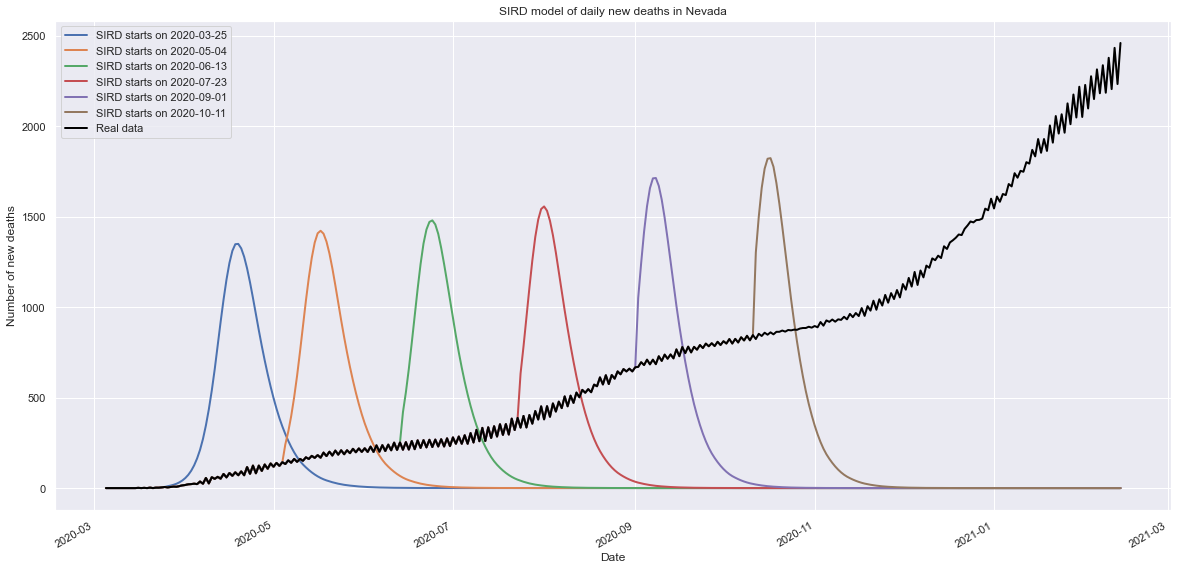

SIRD simulation starts on 2020-03-22 in New Hampshire:
For a population of 1359711 people, after 329 days there were:
0.0% total deaths, or 0 people.
0.0% total recovered, or 0 people.
At the virus' maximum 0.0% people were simultaneously infected, or 0 people.
After 329 days the virus was present in less than 0 individuals.

SIRD simulation starts on 2020-05-01 in New Hampshire:
For a population of 1359711 people, after 289 days there were:
0.9% total deaths, or 11879 people.
87.4% total recovered, or 1187942 people.
At the virus' maximum 22.7% people were simultaneously infected, or 308736 people.
After 289 days the virus was present in less than 1 individuals.

SIRD simulation starts on 2020-06-10 in New Hampshire:
For a population of 1359711 people, after 249 days there were:
0.9% total deaths, or 11985 people.
88.1% total recovered, or 1198493 people.
At the virus' maximum 24.9% people were simultaneously infected, or 338049 people.
After 249 days the virus was present in less tha

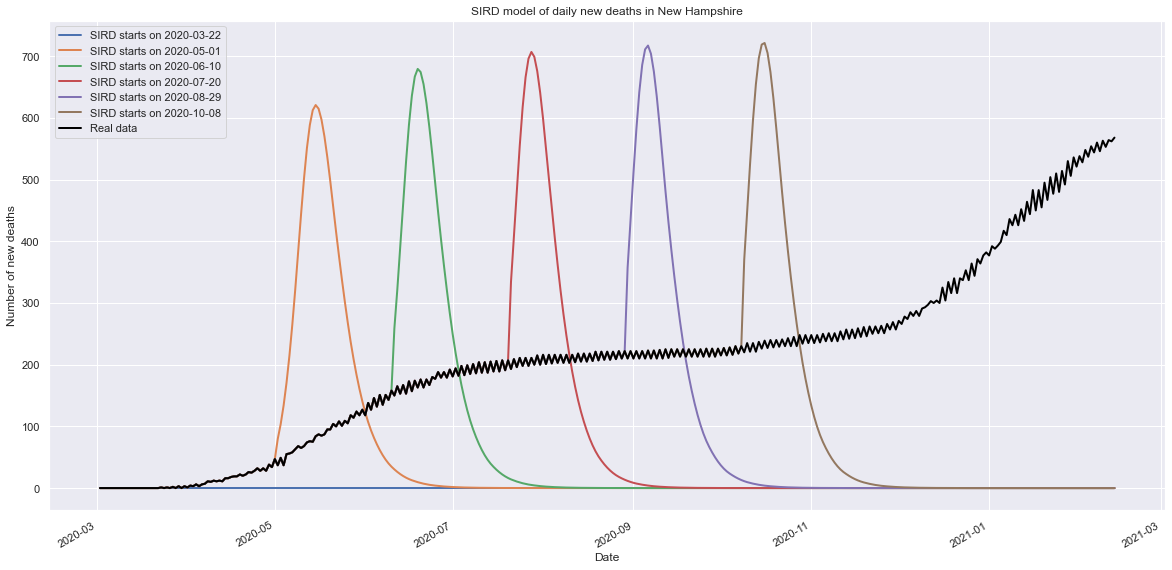

SIRD simulation starts on 2020-03-24 in New Jersey:
For a population of 8882190 people, after 327 days there were:
0.9% total deaths, or 77307 people.
87.0% total recovered, or 7730666 people.
At the virus' maximum 22.0% people were simultaneously infected, or 1951643 people.
After 327 days the virus was present in less than 6 individuals.

SIRD simulation starts on 2020-05-03 in New Jersey:
For a population of 8882190 people, after 287 days there were:
0.9% total deaths, or 80757 people.
90.9% total recovered, or 8075651 people.
At the virus' maximum 34.3% people were simultaneously infected, or 3047096 people.
After 287 days the virus was present in less than 4 individuals.

SIRD simulation starts on 2020-06-12 in New Jersey:
For a population of 8882190 people, after 247 days there were:
0.9% total deaths, or 82637 people.
93.0% total recovered, or 8263677 people.
At the virus' maximum 44.6% people were simultaneously infected, or 3965226 people.
After 247 days the virus was present 

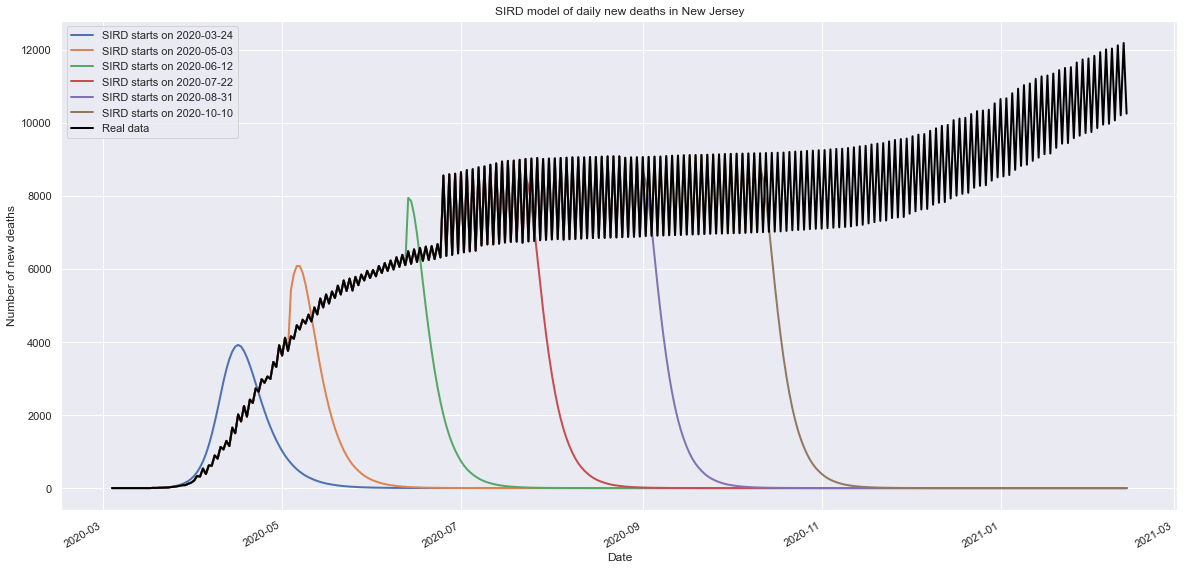

SIRD simulation starts on 2020-03-31 in New Mexico:
For a population of 2096829 people, after 320 days there were:
0.9% total deaths, or 18254 people.
87.1% total recovered, or 1825392 people.
At the virus' maximum 21.9% people were simultaneously infected, or 459314 people.
After 320 days the virus was present in less than 1 individuals.

SIRD simulation starts on 2020-05-10 in New Mexico:
For a population of 2096829 people, after 280 days there were:
0.9% total deaths, or 18295 people.
87.2% total recovered, or 1829453 people.
At the virus' maximum 23.1% people were simultaneously infected, or 485207 people.
After 280 days the virus was present in less than 1 individuals.

SIRD simulation starts on 2020-06-19 in New Mexico:
For a population of 2096829 people, after 240 days there were:
0.9% total deaths, or 18480 people.
88.1% total recovered, or 1848016 people.
At the virus' maximum 24.8% people were simultaneously infected, or 520746 people.
After 240 days the virus was present in 

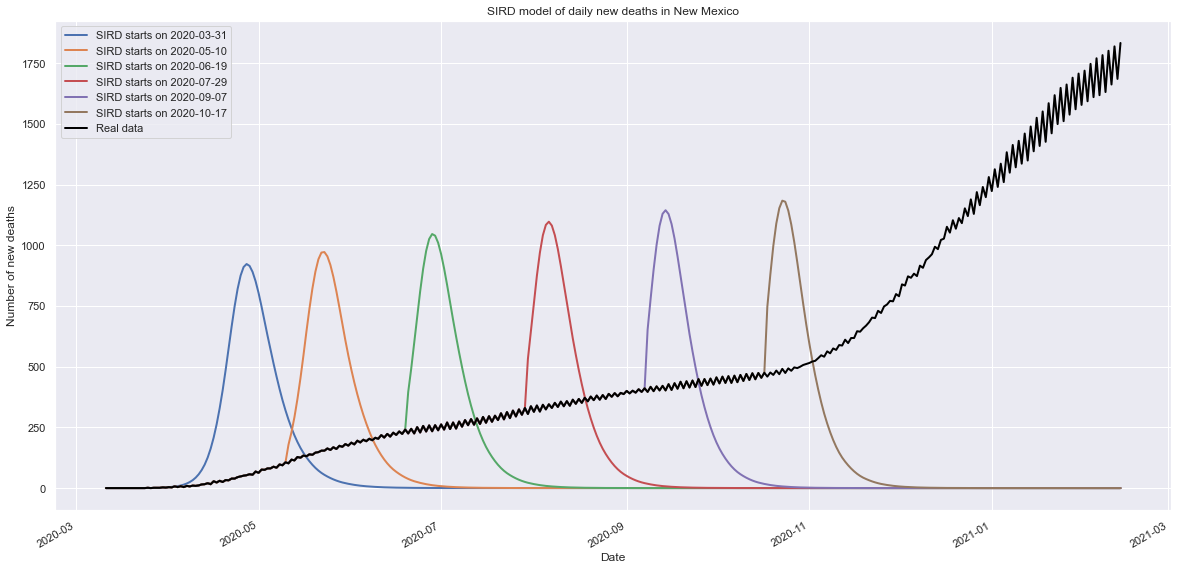

SIRD simulation starts on 2020-03-21 in New York:
For a population of 19453561 people, after 330 days there were:
0.9% total deaths, or 168972 people.
86.9% total recovered, or 16897187 people.
At the virus' maximum 21.9% people were simultaneously infected, or 4255650 people.
After 330 days the virus was present in less than 5 individuals.

SIRD simulation starts on 2020-04-30 in New York:
For a population of 19453561 people, after 290 days there were:
0.9% total deaths, or 179637 people.
92.3% total recovered, or 17963749 people.
At the virus' maximum 40.7% people were simultaneously infected, or 7910413 people.
After 290 days the virus was present in less than 10 individuals.

SIRD simulation starts on 2020-06-09 in New York:
For a population of 19453561 people, after 250 days there were:
0.9% total deaths, or 182182 people.
93.6% total recovered, or 18218203 people.
At the virus' maximum 48.7% people were simultaneously infected, or 9481712 people.
After 250 days the virus was pres

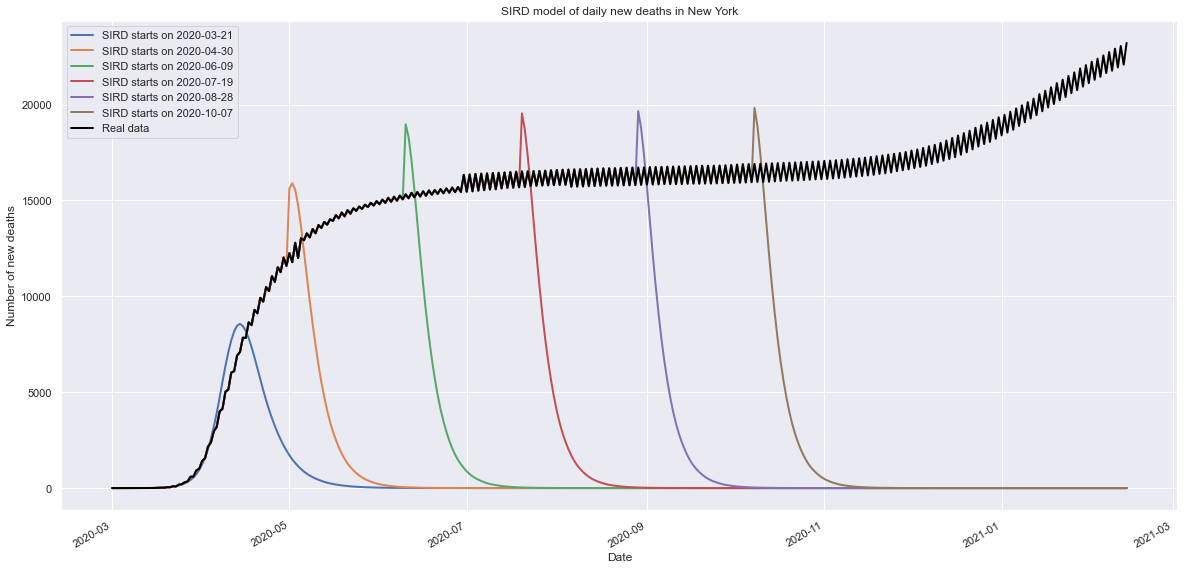

SIRD simulation starts on 2020-03-23 in North Carolina:
For a population of 10488084 people, after 328 days there were:
0.0% total deaths, or 0 people.
0.0% total recovered, or 0 people.
At the virus' maximum 0.0% people were simultaneously infected, or 0 people.
After 328 days the virus was present in less than 0 individuals.

SIRD simulation starts on 2020-05-02 in North Carolina:
For a population of 10488084 people, after 288 days there were:
0.9% total deaths, or 91501 people.
87.2% total recovered, or 9150065 people.
At the virus' maximum 22.5% people were simultaneously infected, or 2354588 people.
After 288 days the virus was present in less than 2 individuals.

SIRD simulation starts on 2020-06-11 in North Carolina:
For a population of 10488084 people, after 248 days there were:
0.9% total deaths, or 91309 people.
87.1% total recovered, or 9130945 people.
At the virus' maximum 23.1% people were simultaneously infected, or 2420896 people.
After 248 days the virus was present in 

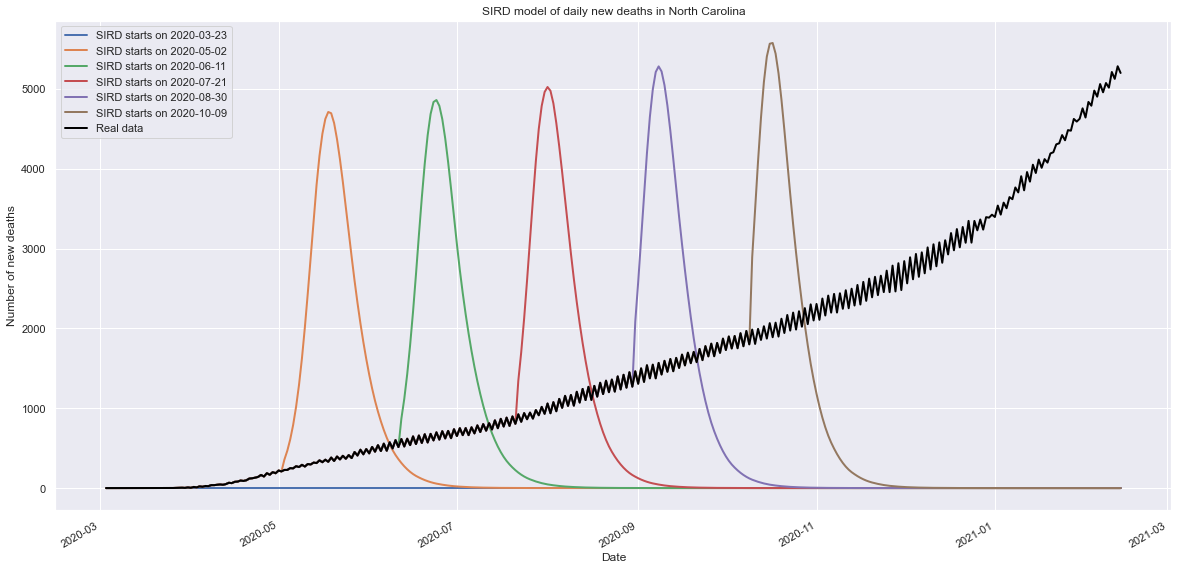

SIRD simulation starts on 2020-03-31 in North Dakota:
For a population of 762062 people, after 320 days there were:
0.9% total deaths, or 6627 people.
87.0% total recovered, or 662671 people.
At the virus' maximum 21.9% people were simultaneously infected, or 166740 people.
After 320 days the virus was present in less than 0 individuals.

SIRD simulation starts on 2020-05-10 in North Dakota:
For a population of 762062 people, after 280 days there were:
0.9% total deaths, or 6653 people.
87.3% total recovered, or 665322 people.
At the virus' maximum 22.5% people were simultaneously infected, or 171641 people.
After 280 days the virus was present in less than 0 individuals.

SIRD simulation starts on 2020-06-19 in North Dakota:
For a population of 762062 people, after 240 days there were:
0.9% total deaths, or 6644 people.
87.2% total recovered, or 664400 people.
At the virus' maximum 23.1% people were simultaneously infected, or 176158 people.
After 240 days the virus was present in les

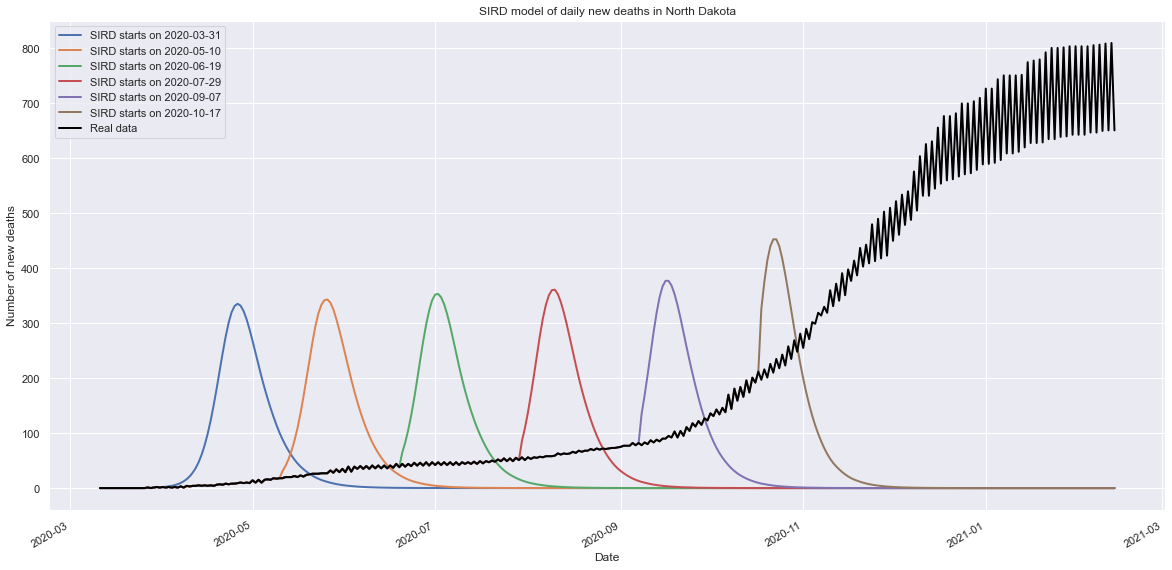

SIRD simulation starts on 2020-03-29 in Ohio:
For a population of 11689100 people, after 322 days there were:
0.9% total deaths, or 100579 people.
86.0% total recovered, or 10057865 people.
At the virus' maximum 21.9% people were simultaneously infected, or 2555234 people.
After 322 days the virus was present in less than 12 individuals.

SIRD simulation starts on 2020-05-08 in Ohio:
For a population of 11689100 people, after 282 days there were:
0.9% total deaths, or 102214 people.
87.4% total recovered, or 10221362 people.
At the virus' maximum 23.3% people were simultaneously infected, or 2718400 people.
After 282 days the virus was present in less than 2 individuals.

SIRD simulation starts on 2020-06-17 in Ohio:
For a population of 11689100 people, after 242 days there were:
0.9% total deaths, or 102965 people.
88.1% total recovered, or 10296490 people.
At the virus' maximum 24.7% people were simultaneously infected, or 2886518 people.
After 242 days the virus was present in less 

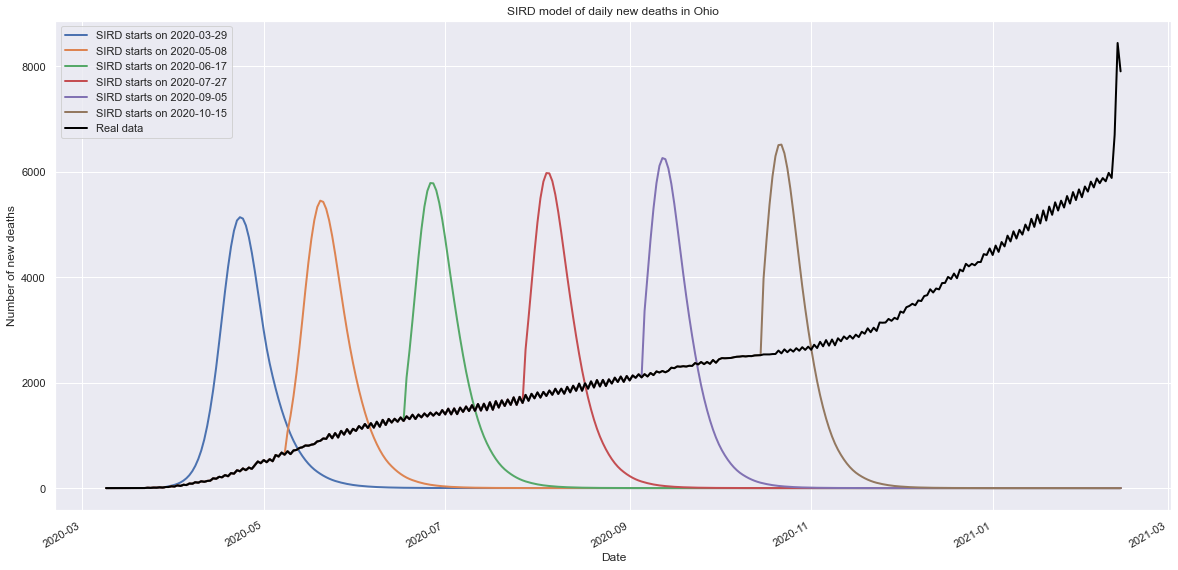

SIRD simulation starts on 2020-03-26 in Oklahoma:
For a population of 3956971 people, after 325 days there were:
0.9% total deaths, or 34444 people.
87.0% total recovered, or 3444398 people.
At the virus' maximum 21.9% people were simultaneously infected, or 866150 people.
After 325 days the virus was present in less than 2 individuals.

SIRD simulation starts on 2020-05-05 in Oklahoma:
For a population of 3956971 people, after 285 days there were:
0.9% total deaths, or 34573 people.
87.4% total recovered, or 3457263 people.
At the virus' maximum 22.7% people were simultaneously infected, or 898272 people.
After 285 days the virus was present in less than 3 individuals.

SIRD simulation starts on 2020-06-14 in Oklahoma:
For a population of 3956971 people, after 245 days there were:
0.9% total deaths, or 34477 people.
87.1% total recovered, or 3447662 people.
At the virus' maximum 23.0% people were simultaneously infected, or 909925 people.
After 245 days the virus was present in less t

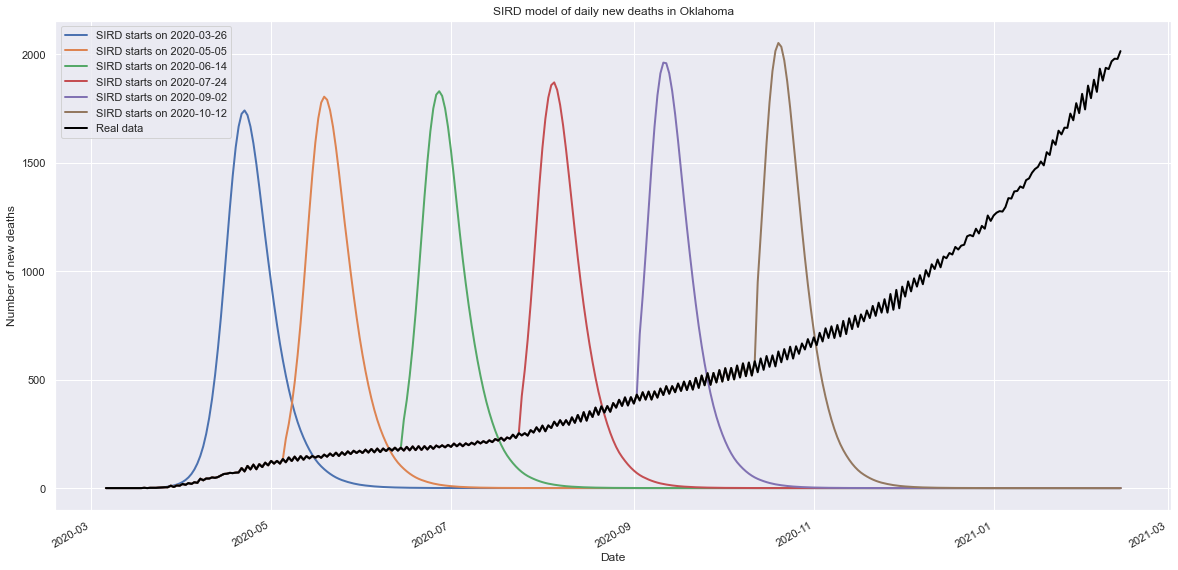

SIRD simulation starts on 2020-03-19 in Oregon:
For a population of 4217737 people, after 332 days there were:
0.9% total deaths, or 36727 people.
87.1% total recovered, or 3672668 people.
At the virus' maximum 22.0% people were simultaneously infected, or 926554 people.
After 332 days the virus was present in less than 2 individuals.

SIRD simulation starts on 2020-04-28 in Oregon:
For a population of 4217737 people, after 292 days there were:
0.9% total deaths, or 36719 people.
87.1% total recovered, or 3671867 people.
At the virus' maximum 22.1% people were simultaneously infected, or 932287 people.
After 292 days the virus was present in less than 7 individuals.

SIRD simulation starts on 2020-06-07 in Oregon:
For a population of 4217737 people, after 252 days there were:
0.9% total deaths, or 36796 people.
87.2% total recovered, or 3679646 people.
At the virus' maximum 22.4% people were simultaneously infected, or 946846 people.
After 252 days the virus was present in less than 1 

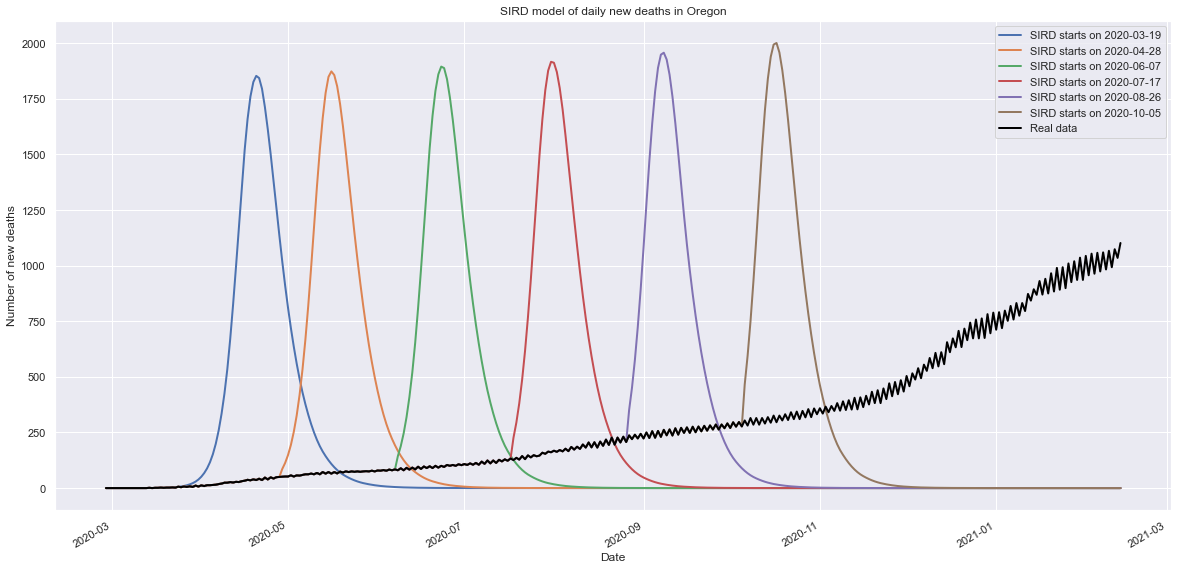

SIRD simulation starts on 2020-03-26 in Pennsylvania:
For a population of 12801989 people, after 325 days there were:
0.9% total deaths, or 111486 people.
87.1% total recovered, or 11148631 people.
At the virus' maximum 21.9% people were simultaneously infected, or 2806547 people.
After 325 days the virus was present in less than 3 individuals.

SIRD simulation starts on 2020-05-05 in Pennsylvania:
For a population of 12801989 people, after 285 days there were:
0.9% total deaths, or 113061 people.
88.3% total recovered, or 11306065 people.
At the virus' maximum 25.4% people were simultaneously infected, or 3255890 people.
After 285 days the virus was present in less than 13 individuals.

SIRD simulation starts on 2020-06-14 in Pennsylvania:
For a population of 12801989 people, after 245 days there were:
0.9% total deaths, or 114594 people.
89.5% total recovered, or 11459424 people.
At the virus' maximum 29.0% people were simultaneously infected, or 3715069 people.
After 245 days the vi

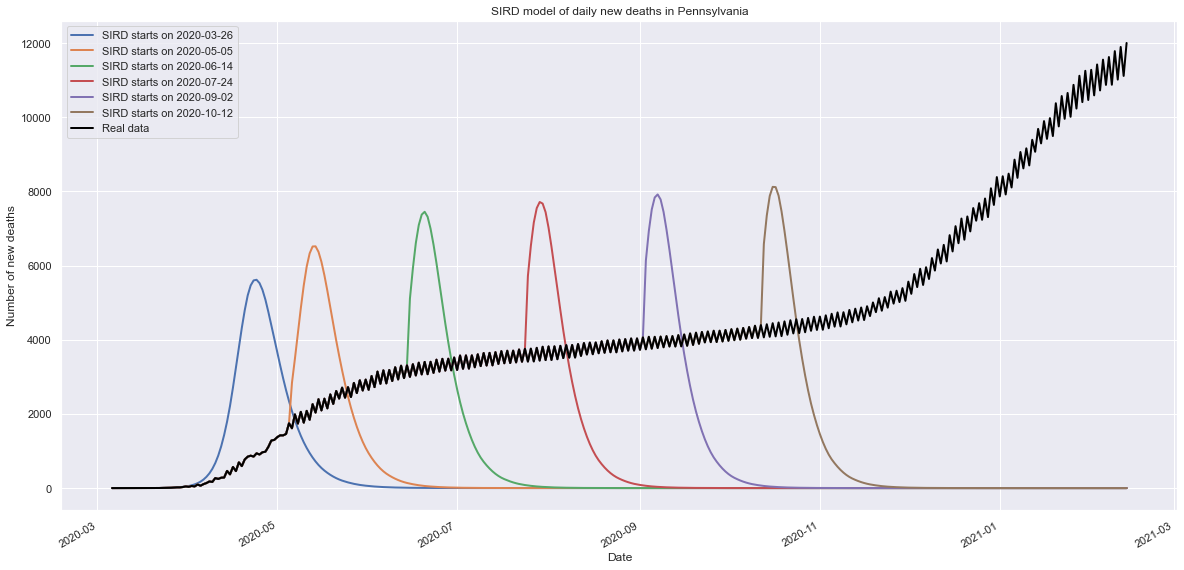

SIRD simulation starts on 2020-04-02 in Puerto Rico:
For a population of 3193694 people, after 318 days there were:
0.9% total deaths, or 27759 people.
86.9% total recovered, or 2775916 people.
At the virus' maximum 21.9% people were simultaneously infected, or 700405 people.
After 318 days the virus was present in less than 1 individuals.

SIRD simulation starts on 2020-05-12 in Puerto Rico:
For a population of 3193694 people, after 278 days there were:
0.9% total deaths, or 27852 people.
87.2% total recovered, or 2785236 people.
At the virus' maximum 22.4% people were simultaneously infected, or 715939 people.
After 278 days the virus was present in less than 1 individuals.

SIRD simulation starts on 2020-06-21 in Puerto Rico:
For a population of 3193694 people, after 238 days there were:
0.9% total deaths, or 27878 people.
87.3% total recovered, or 2787754 people.
At the virus' maximum 22.5% people were simultaneously infected, or 718129 people.
After 238 days the virus was present 

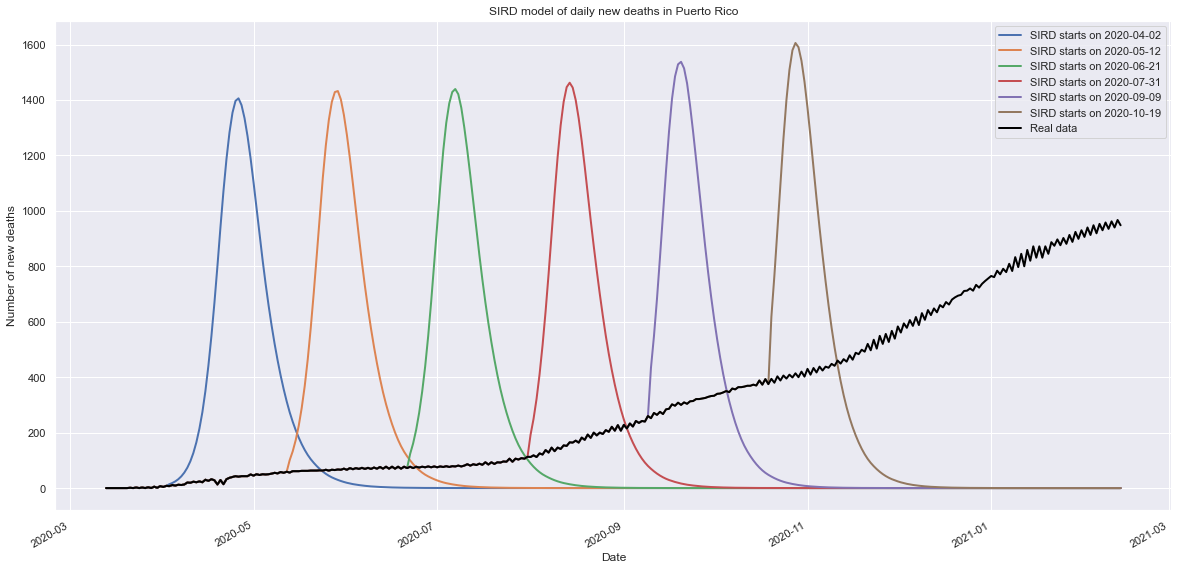

SIRD simulation starts on 2020-03-21 in Rhode Island:
For a population of 1059361 people, after 330 days there were:
0.0% total deaths, or 0 people.
0.0% total recovered, or 0 people.
At the virus' maximum 0.0% people were simultaneously infected, or 0 people.
After 330 days the virus was present in less than 0 individuals.

SIRD simulation starts on 2020-04-30 in Rhode Island:
For a population of 1059361 people, after 290 days there were:
0.9% total deaths, or 9343 people.
88.2% total recovered, or 934267 people.
At the virus' maximum 25.1% people were simultaneously infected, or 266095 people.
After 290 days the virus was present in less than 1 individuals.

SIRD simulation starts on 2020-06-09 in Rhode Island:
For a population of 1059361 people, after 250 days there were:
0.9% total deaths, or 9574 people.
90.4% total recovered, or 957408 people.
At the virus' maximum 32.2% people were simultaneously infected, or 340909 people.
After 250 days the virus was present in less than 1 ind

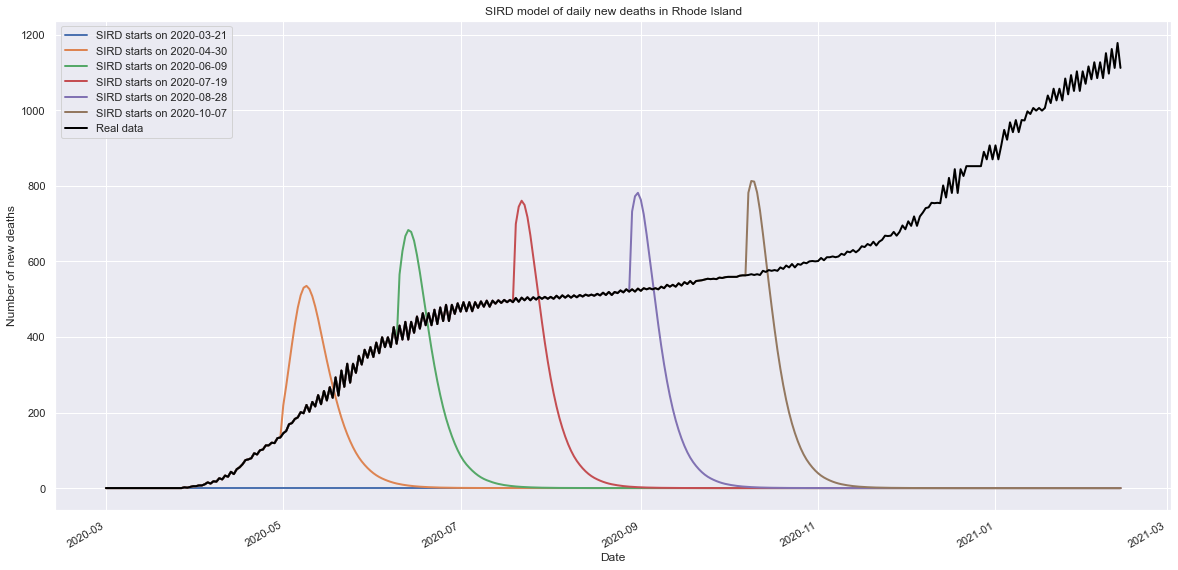

SIRD simulation starts on 2020-03-26 in South Carolina:
For a population of 5148714 people, after 325 days there were:
0.9% total deaths, or 44759 people.
86.9% total recovered, or 4475869 people.
At the virus' maximum 21.9% people were simultaneously infected, or 1127049 people.
After 325 days the virus was present in less than 2 individuals.

SIRD simulation starts on 2020-05-05 in South Carolina:
For a population of 5148714 people, after 285 days there were:
0.9% total deaths, or 44987 people.
87.4% total recovered, or 4498668 people.
At the virus' maximum 22.7% people were simultaneously infected, or 1167663 people.
After 285 days the virus was present in less than 2 individuals.

SIRD simulation starts on 2020-06-14 in South Carolina:
For a population of 5148714 people, after 245 days there were:
0.9% total deaths, or 45128 people.
87.6% total recovered, or 4512830 people.
At the virus' maximum 23.6% people were simultaneously infected, or 1212928 people.
After 245 days the virus 

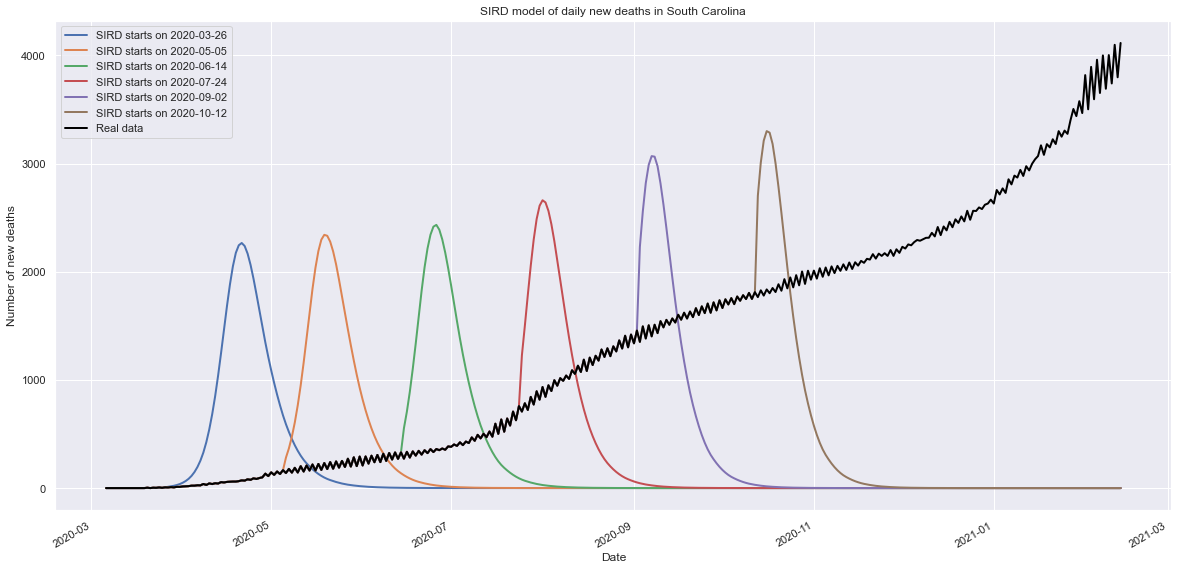

SIRD simulation starts on 2020-03-30 in South Dakota:
For a population of 884659 people, after 321 days there were:
0.9% total deaths, or 7699 people.
87.0% total recovered, or 769852 people.
At the virus' maximum 21.9% people were simultaneously infected, or 194067 people.
After 321 days the virus was present in less than 0 individuals.

SIRD simulation starts on 2020-05-09 in South Dakota:
For a population of 884659 people, after 281 days there were:
0.9% total deaths, or 7719 people.
87.3% total recovered, or 771871 people.
At the virus' maximum 22.5% people were simultaneously infected, or 198620 people.
After 281 days the virus was present in less than 0 individuals.

SIRD simulation starts on 2020-06-18 in South Dakota:
For a population of 884659 people, after 241 days there were:
0.9% total deaths, or 7685 people.
86.9% total recovered, or 768515 people.
At the virus' maximum 22.9% people were simultaneously infected, or 202813 people.
After 241 days the virus was present in les

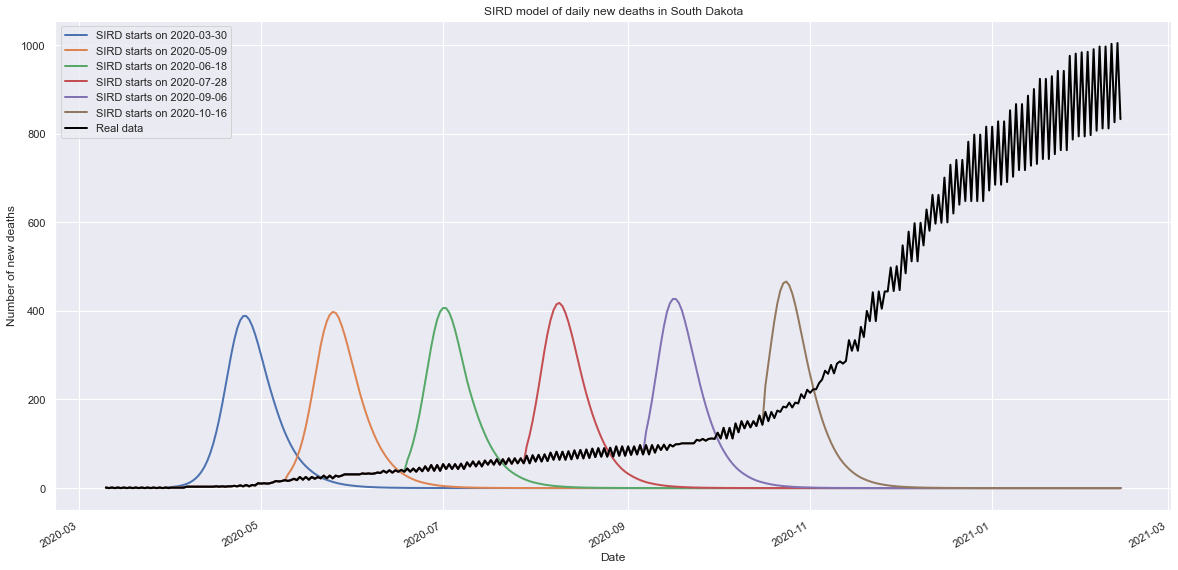

SIRD simulation starts on 2020-03-25 in Tennessee:
For a population of 6829174 people, after 326 days there were:
0.9% total deaths, or 59473 people.
87.1% total recovered, or 5947300 people.
At the virus' maximum 21.9% people were simultaneously infected, or 1495925 people.
After 326 days the virus was present in less than 2 individuals.

SIRD simulation starts on 2020-05-04 in Tennessee:
For a population of 6829174 people, after 286 days there were:
0.9% total deaths, or 59530 people.
87.2% total recovered, or 5952984 people.
At the virus' maximum 22.3% people were simultaneously infected, or 1525139 people.
After 286 days the virus was present in less than 1 individuals.

SIRD simulation starts on 2020-06-13 in Tennessee:
For a population of 6829174 people, after 246 days there were:
0.9% total deaths, or 59669 people.
87.4% total recovered, or 5966875 people.
At the virus' maximum 22.7% people were simultaneously infected, or 1549899 people.
After 246 days the virus was present in 

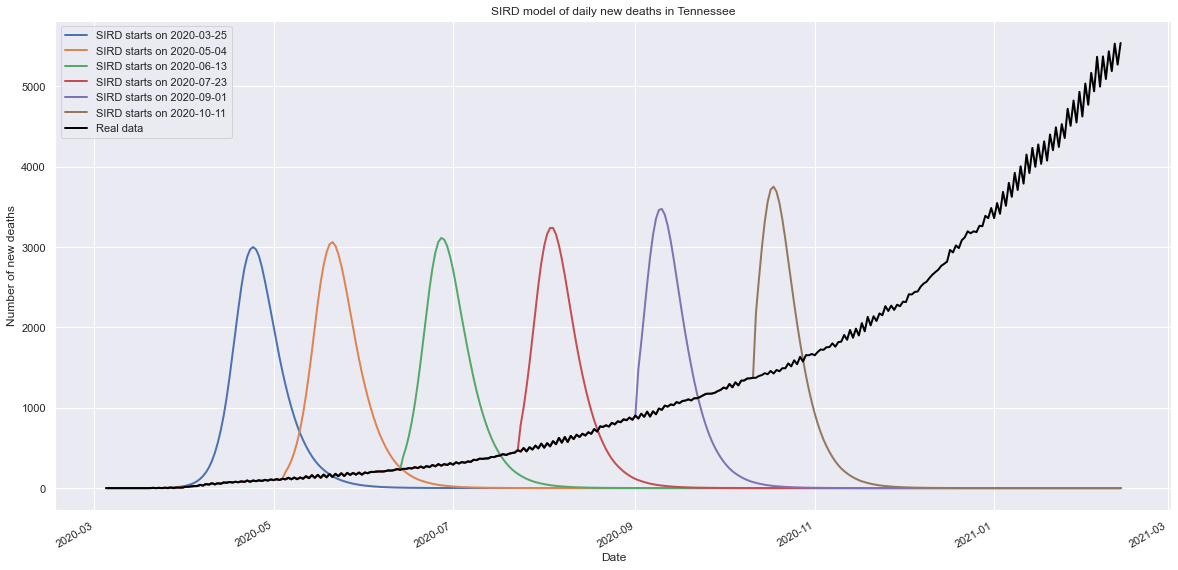

SIRD simulation starts on 2020-03-03 in Texas:
For a population of 28995881 people, after 348 days there were:
0.0% total deaths, or 0 people.
0.0% total recovered, or 0 people.
At the virus' maximum 0.0% people were simultaneously infected, or 0 people.
After 348 days the virus was present in less than 0 individuals.

SIRD simulation starts on 2020-04-12 in Texas:
For a population of 28995881 people, after 308 days there were:
0.9% total deaths, or 252638 people.
87.1% total recovered, or 25263781 people.
At the virus' maximum 22.1% people were simultaneously infected, or 6394611 people.
After 308 days the virus was present in less than 29 individuals.

SIRD simulation starts on 2020-05-22 in Texas:
For a population of 28995881 people, after 268 days there were:
0.9% total deaths, or 253223 people.
87.3% total recovered, or 25322258 people.
At the virus' maximum 22.6% people were simultaneously infected, or 6539374 people.
After 268 days the virus was present in less than 16 individua

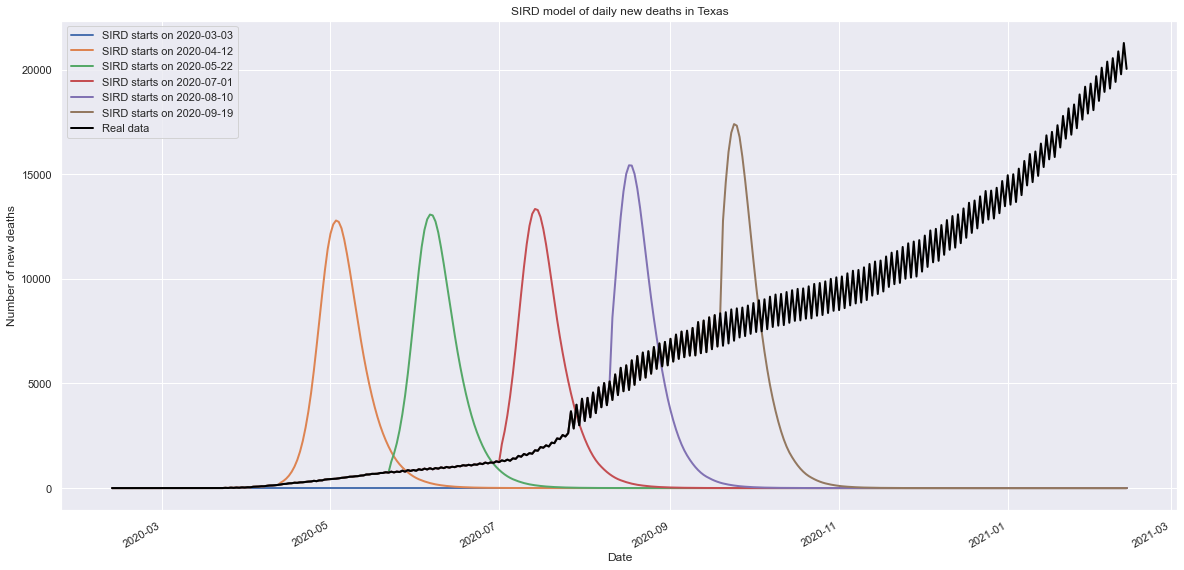

SIRD simulation starts on 2020-03-16 in Utah:
For a population of 3205958 people, after 335 days there were:
0.0% total deaths, or 0 people.
0.0% total recovered, or 0 people.
At the virus' maximum 0.0% people were simultaneously infected, or 0 people.
After 335 days the virus was present in less than 0 individuals.

SIRD simulation starts on 2020-04-25 in Utah:
For a population of 3205958 people, after 295 days there were:
0.9% total deaths, or 27935 people.
87.1% total recovered, or 2793526 people.
At the virus' maximum 22.0% people were simultaneously infected, or 705799 people.
After 295 days the virus was present in less than 1 individuals.

SIRD simulation starts on 2020-06-04 in Utah:
For a population of 3205958 people, after 255 days there were:
0.9% total deaths, or 27961 people.
87.2% total recovered, or 2796115 people.
At the virus' maximum 22.4% people were simultaneously infected, or 718963 people.
After 255 days the virus was present in less than 1 individuals.

SIRD simu

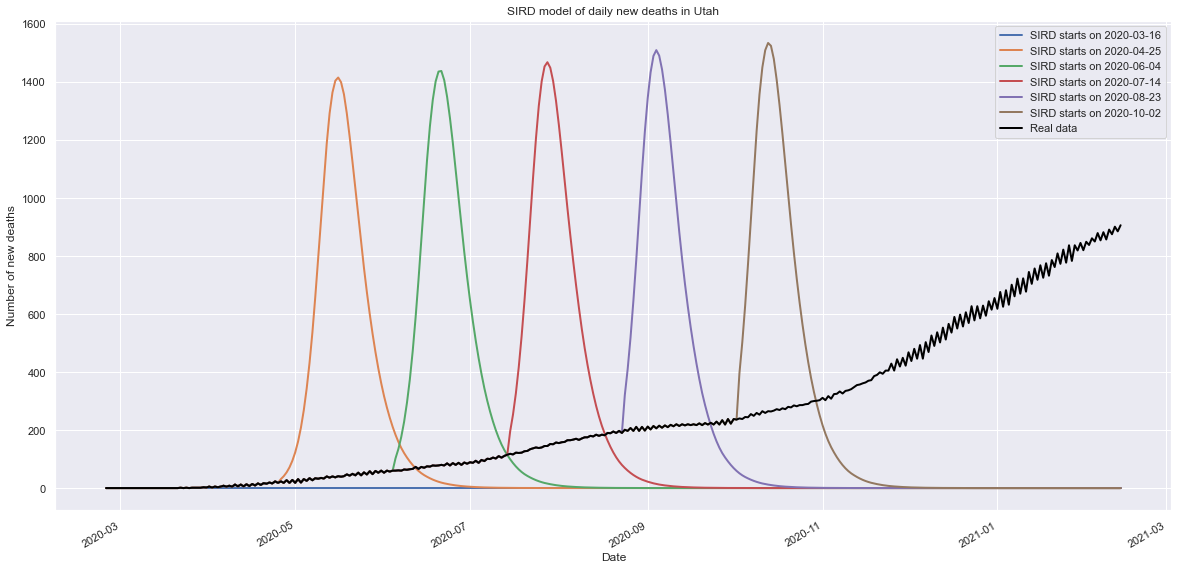

SIRD simulation starts on 2020-03-27 in Vermont:
For a population of 623989 people, after 324 days there were:
0.9% total deaths, or 5437 people.
87.1% total recovered, or 543741 people.
At the virus' maximum 22.1% people were simultaneously infected, or 137618 people.
After 324 days the virus was present in less than 1 individuals.

SIRD simulation starts on 2020-05-06 in Vermont:
For a population of 623989 people, after 284 days there were:
0.9% total deaths, or 5423 people.
86.9% total recovered, or 542343 people.
At the virus' maximum 22.9% people were simultaneously infected, or 143032 people.
After 284 days the virus was present in less than 0 individuals.

SIRD simulation starts on 2020-06-15 in Vermont:
For a population of 623989 people, after 244 days there were:
0.9% total deaths, or 5439 people.
87.2% total recovered, or 543925 people.
At the virus' maximum 22.9% people were simultaneously infected, or 143106 people.
After 244 days the virus was present in less than 0 indivi

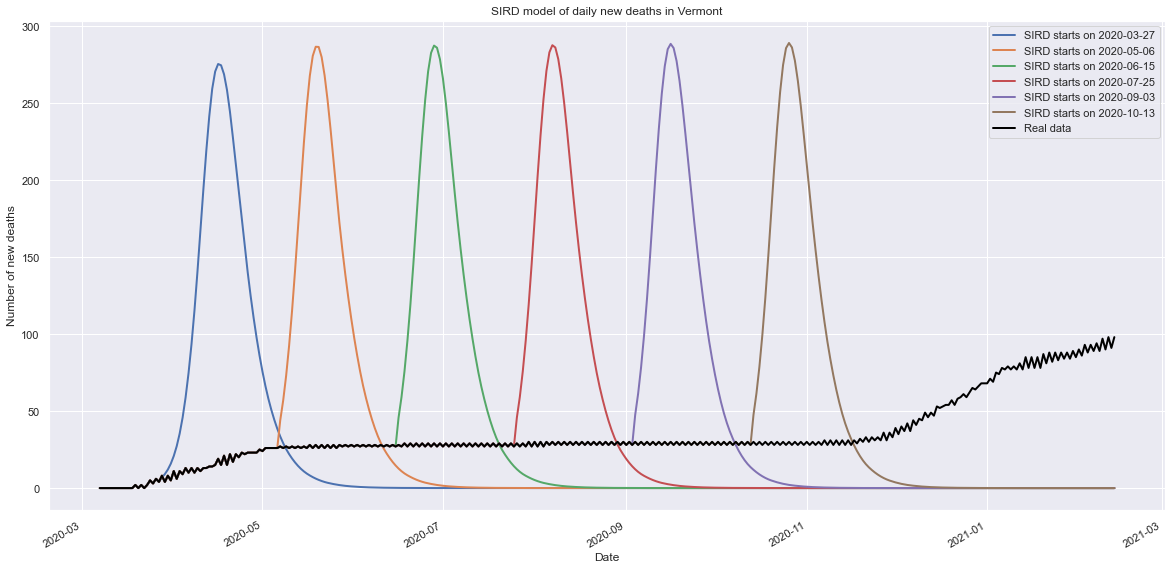

SIRD simulation starts on 2020-03-27 in Virginia:
For a population of 8535519 people, after 324 days there were:
0.9% total deaths, or 74333 people.
87.1% total recovered, or 7433333 people.
At the virus' maximum 21.9% people were simultaneously infected, or 1872276 people.
After 324 days the virus was present in less than 3 individuals.

SIRD simulation starts on 2020-05-06 in Virginia:
For a population of 8535519 people, after 284 days there were:
0.9% total deaths, or 74576 people.
87.4% total recovered, or 7457558 people.
At the virus' maximum 22.7% people were simultaneously infected, or 1937760 people.
After 284 days the virus was present in less than 7 individuals.

SIRD simulation starts on 2020-06-15 in Virginia:
For a population of 8535519 people, after 244 days there were:
0.9% total deaths, or 75029 people.
87.9% total recovered, or 7502912 people.
At the virus' maximum 24.1% people were simultaneously infected, or 2053519 people.
After 244 days the virus was present in les

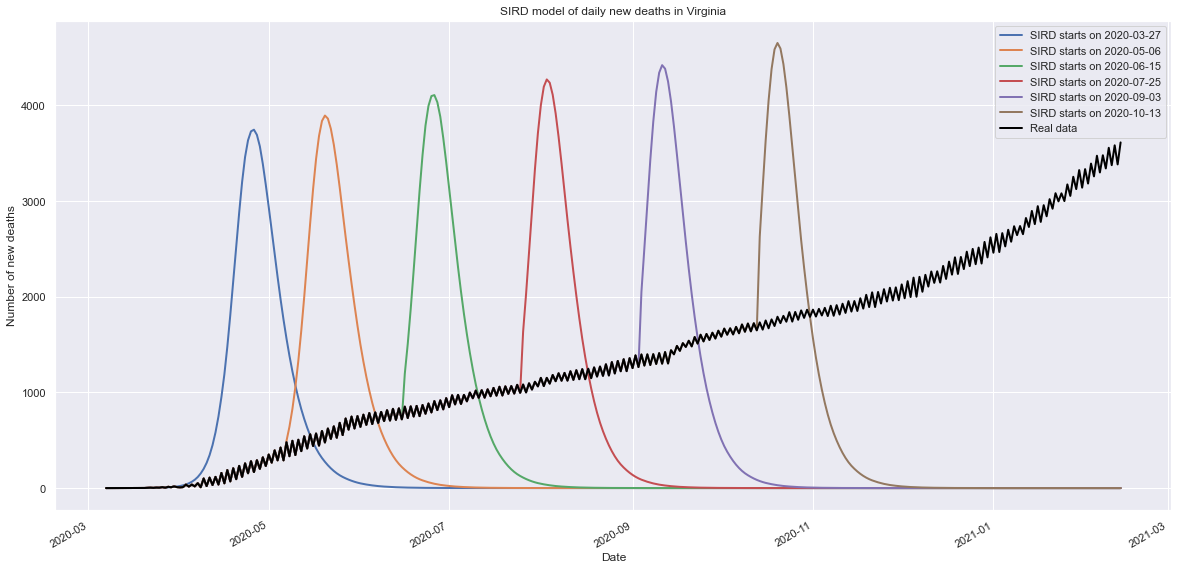

SIRD simulation starts on 2020-02-10 in Washington:
For a population of 7614893 people, after 370 days there were:
0.0% total deaths, or 0 people.
0.0% total recovered, or 0 people.
At the virus' maximum 0.0% people were simultaneously infected, or 0 people.
After 370 days the virus was present in less than 0 individuals.

SIRD simulation starts on 2020-03-21 in Washington:
For a population of 7614893 people, after 330 days there were:
0.9% total deaths, or 66355 people.
87.1% total recovered, or 6635519 people.
At the virus' maximum 22.1% people were simultaneously infected, or 1679120 people.
After 330 days the virus was present in less than 4 individuals.

SIRD simulation starts on 2020-04-30 in Washington:
For a population of 7614893 people, after 290 days there were:
0.9% total deaths, or 66632 people.
87.5% total recovered, or 6663212 people.
At the virus' maximum 23.3% people were simultaneously infected, or 1774915 people.
After 290 days the virus was present in less than 5 ind

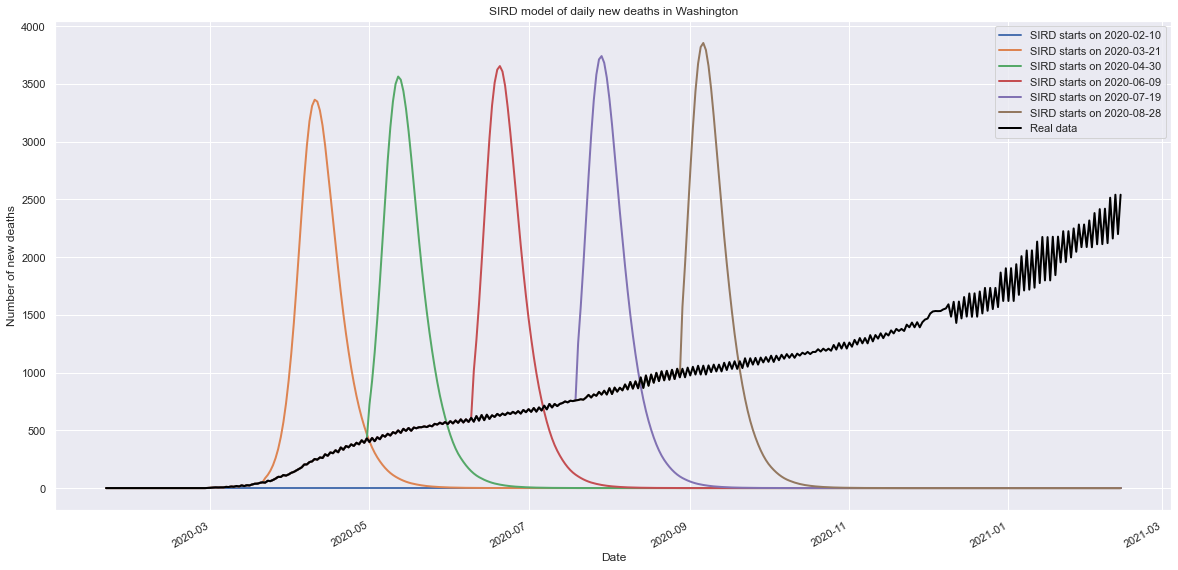

SIRD simulation starts on 2020-04-06 in West Virginia:
For a population of 1792147 people, after 314 days there were:
0.9% total deaths, or 15596 people.
87.0% total recovered, or 1559626 people.
At the virus' maximum 21.9% people were simultaneously infected, or 393118 people.
After 314 days the virus was present in less than 0 individuals.

SIRD simulation starts on 2020-05-16 in West Virginia:
For a population of 1792147 people, after 274 days there were:
0.9% total deaths, or 15634 people.
87.2% total recovered, or 1563364 people.
At the virus' maximum 22.4% people were simultaneously infected, or 402250 people.
After 274 days the virus was present in less than 1 individuals.

SIRD simulation starts on 2020-06-25 in West Virginia:
For a population of 1792147 people, after 234 days there were:
0.9% total deaths, or 15655 people.
87.4% total recovered, or 1565534 people.
At the virus' maximum 22.5% people were simultaneously infected, or 403800 people.
After 234 days the virus was pr

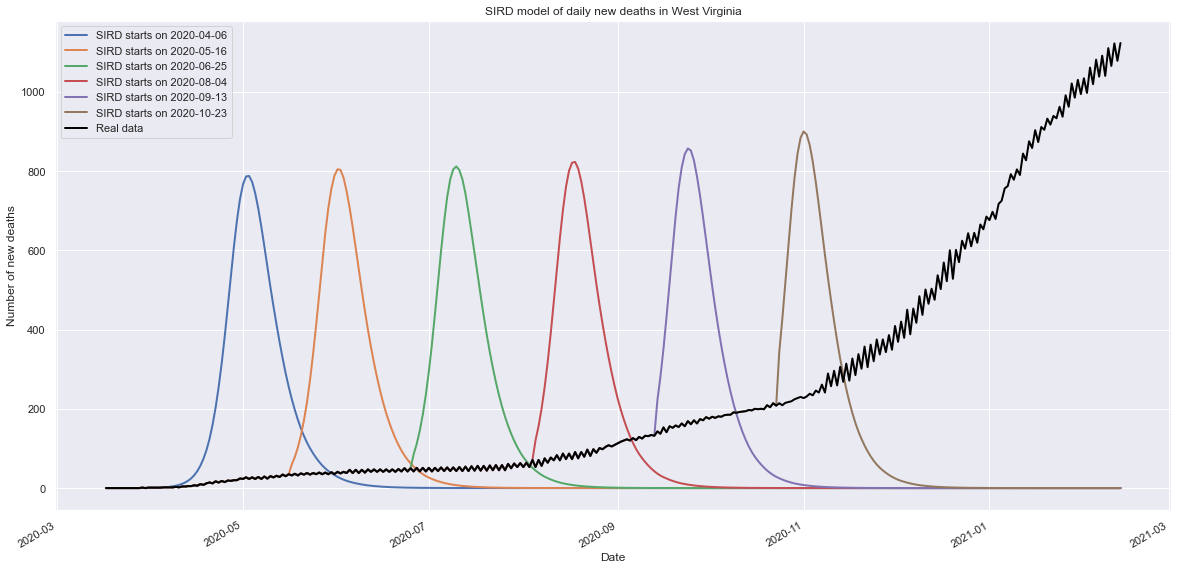

SIRD simulation starts on 2020-02-25 in Wisconsin:
For a population of 5822434 people, after 355 days there were:
0.0% total deaths, or 0 people.
0.0% total recovered, or 0 people.
At the virus' maximum 0.0% people were simultaneously infected, or 0 people.
After 355 days the virus was present in less than 0 individuals.

SIRD simulation starts on 2020-04-05 in Wisconsin:
For a population of 5822434 people, after 315 days there were:
0.9% total deaths, or 50732 people.
87.1% total recovered, or 5073210 people.
At the virus' maximum 22.0% people were simultaneously infected, or 1282078 people.
After 315 days the virus was present in less than 1 individuals.

SIRD simulation starts on 2020-05-15 in Wisconsin:
For a population of 5822434 people, after 275 days there were:
0.9% total deaths, or 50774 people.
87.2% total recovered, or 5077353 people.
At the virus' maximum 22.9% people were simultaneously infected, or 1331805 people.
After 275 days the virus was present in less than 4 indivi

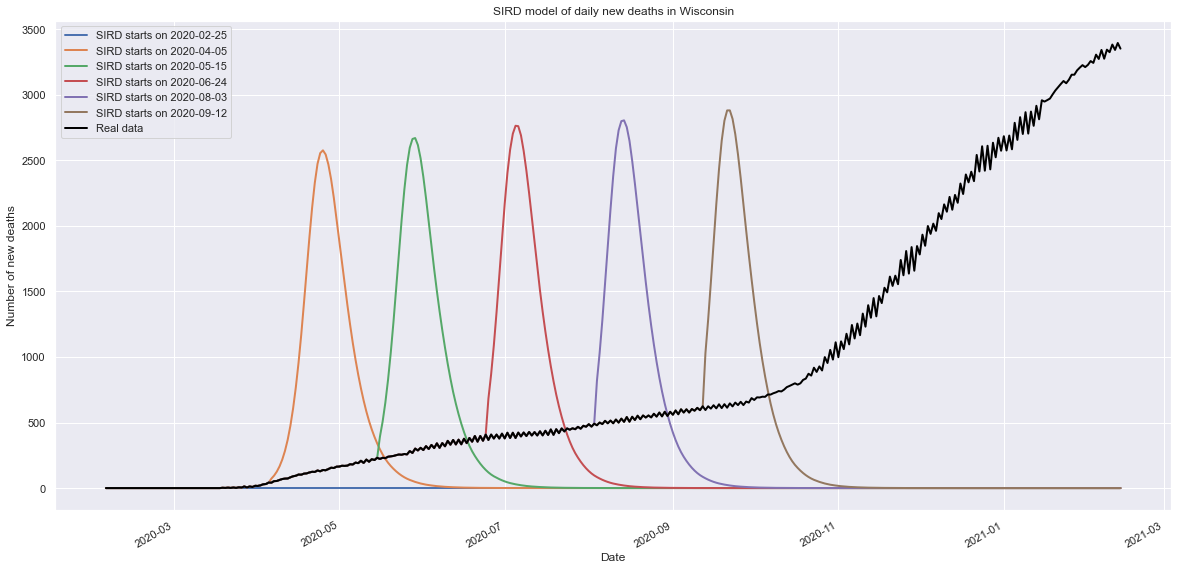

SIRD simulation starts on 2020-03-31 in Wyoming:
For a population of 578759 people, after 320 days there were:
0.0% total deaths, or 0 people.
0.0% total recovered, or 0 people.
At the virus' maximum 0.0% people were simultaneously infected, or 0 people.
After 320 days the virus was present in less than 0 individuals.

SIRD simulation starts on 2020-05-10 in Wyoming:
For a population of 578759 people, after 280 days there were:
0.9% total deaths, or 5028 people.
86.9% total recovered, or 502836 people.
At the virus' maximum 21.9% people were simultaneously infected, or 126611 people.
After 280 days the virus was present in less than 0 individuals.

SIRD simulation starts on 2020-06-19 in Wyoming:
For a population of 578759 people, after 240 days there were:
0.9% total deaths, or 5042 people.
87.1% total recovered, or 504185 people.
At the virus' maximum 22.3% people were simultaneously infected, or 128852 people.
After 240 days the virus was present in less than 0 individuals.

SIRD si

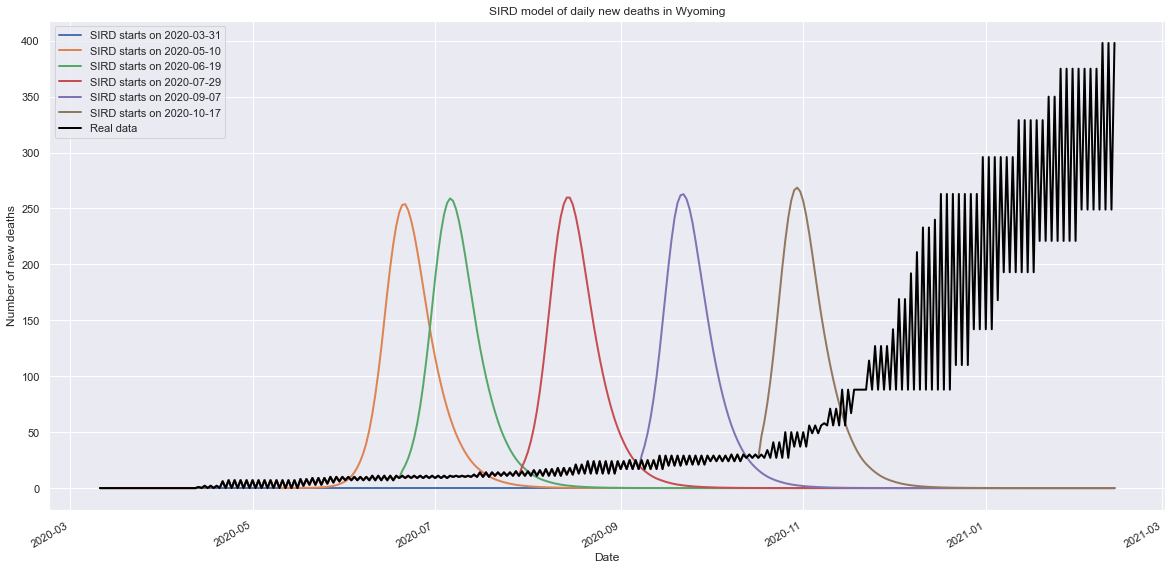

In [4]:
# Read each state's population
dataPop = pd.read_csv("nst-est2019-alldata.csv")
dataPopSize = len(dataPop.index)
usPop = {}
for i in range(dataPopSize):
    usPop[dataPop.loc[i]["NAME"]] = dataPop.loc[i]["POPESTIMATE2019"]
#print(usPop)

# Read all files
directory = os.fsencode("clean-data/")
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".csv"): 
        f = filename.replace(".csv","")
        #print(filename, f)
        if f in usPop:
            path = "clean-data/"+filename
            dataState = pd.read_csv(path, header=None).values.tolist()
            R0 = 2.4   # Basic Reproductive Rate [people]
            M = 0.01   # Mortality ratio [fraction]
            P = 5     # Average infectious period [days] 
            fig, ax = plt.subplots(figsize=(20, 10))
            check = False
            for x in range(6):
                if x == 5:
                    check = True
                target = 20
                target += 40*x
                targetDate = dataState[target]
                targetDatePre = dataState[target-1]
                initial_conditions = {'population': usPop[f], 'deaths': [targetDatePre[1],targetDate[1]]}
                sird = SIRD(R0, M, P)
                sird.solve(initial_conditions, tf = len(dataState)-target)
                sird.plot(dataState, targetDate[0], fig=fig, ax=ax, check=check, name=f)
            plt.show()
    else:
        pass
